Now downloading from the strongest model (1.542 billion parameters) because it produces the most sophisticated text.

In [ ]:
import os
import sys
import requests
from tqdm import tqdm

subdir = 'data'
if not os.path.exists(subdir):
    os.makedirs(subdir)
subdir = subdir.replace('\\','/') # needed for Windows


# Just downloading outputs from strongest version (xl-1542M)

# The dataset contains train, valid and test sets, but the number of samples
# is so large that we only need the training set (250,000 samples)
filename = 'xl-1542M-k40.train.jsonl'
r = requests.get("https://storage.googleapis.com/gpt-2/output-dataset/v1/" + filename, stream=True)

with open(os.path.join(subdir, filename), 'wb') as f:
    file_size = int(r.headers["content-length"])
    chunk_size = 1000
    with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
        # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            pbar.update(chunk_size)

Fetching xl-1542M-k40.train.jsonl: 1.00kit [00:00, 3.88Mit/s]                                       


In [ ]:
import pandas as pd

In [ ]:
import os
import numpy as np
import keras
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
from textwrap import wrap
from PIL import Image, ImageFile, UnidentifiedImageError
# Increasing maximum limit size for pixels per input image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 933120000

In [ ]:
# Importing Pytorch and transformers from HuggingFace
import torch
# Import nn module for building stacked layers and optimizers
from torch import nn, optim
import torchvision
from torchvision import datasets, models, transforms
# Import modules for dataset configuration and loading
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
# Importing modules for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
# Importing visualization tools
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

# Setting style of matplotlib graphic visualization
%matplotlib inline
%config InlineBackend.figure_format="retina"

# Setting style of seaborn graphic visualization
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
COLOR_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(COLOR_PALETTE))

# Setting parameter figure sizes
rcParams["figure.figsize"] = 12, 8

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Assigning available ressource to device variable, preferrably GPU resource
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print out if GPU or CPU is allocated
if str(device) == "cpu":
    print("CPU is allocated.")
else:
    print("GPU is allocated.")

GPU is allocated.


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
# Clear any cached authorization
!rm -rf /root/.config/Google/DriveFS

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/"

 6013-6003-6010-6012-fsmd.zip
'Atp_2(Jahid)'
'Bachelor Certificate.pdf'
'Colab Notebooks'
'COMPUTER GRAPHICS [F].zip'
'Copy of Zapier: Free email signatures for Gmail.gdoc'
'Cover Letter Siam.docx'
 CV
 Ema
 FA-KES-Dataset.csv
 IELTS.pdf
 Maya
'Md. Samiul Alam Siam.docx'
'Md. Samiul Alam Siam.pdf'
'Md Samiul Alam Siam Picture.jpg'
'Md Samiul Alam Siam Signature.jpg'
 Norsk
 Problem-02-23.gdoc
'Real time big data management - Pie chart 1.gsheet'
 Self
'Siam CV.pdf'
 Suma
 Syeed
 Thesis
 WELFake_Dataset.csv


In [ ]:
# Base path where TSV files are stored
base_path = '/content/drive/My Drive/Thesis/dataset/'

In [ ]:
file_test_name = "multimodal_test_public.tsv"
file_train_name = "multimodal_train.tsv"
file_validate_name = "multimodal_validate.tsv"

df_test = pd.read_csv(base_path + file_test_name, sep='\t')
df_train = pd.read_csv(base_path + file_train_name, sep='\t')
df_validate = pd.read_csv(base_path + file_validate_name, sep='\t')

In [ ]:
# Specify the multiple values you want to filter on
#target_domain = ['i.redd.it', 'i.imgur.com']

target_domain = ['i.redd.it']

# Use boolean indexing with isin() to filter the DataFrame
df_test = df_test[df_test['domain'].isin(target_domain)]
df_validate = df_validate[df_validate['domain'].isin(target_domain)]
df_train = df_train[df_train['domain'].isin(target_domain)]

print(len(df_test))
print(len(df_validate))
print(len(df_train))

18653
18357
176260


In [ ]:
# Splitting complete Fakeddit-dataset into 20% training dataframe
# and 80% backup dataframe
df_train, df_backup = train_test_split(
    df_train,
    test_size=0.8,
    shuffle=True,
    # Apply stratification on basis of 2 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_train["2_way_label"]
)

In [ ]:
# Keeping 80% of data samples for training and 20% for testing purposes
df_train, df_test = train_test_split(
    df_train,
    test_size=0.2,
    shuffle=True,
    # Apply stratification on basis of 2 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_train["2_way_label"]
)

In [ ]:
# Dividing test split dataframe by factor 0,5 to have identically
# sized splits for validation and testing
df_test, df_validate = train_test_split(
    df_test,
    test_size=0.5,
    shuffle=True,
    # Apply stratification on basis of 2 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_test["2_way_label"]
)

In [ ]:
print(len(df_test))
print(len(df_validate))
print(len(df_train))

3525
3526
28201


In [ ]:
df_train.head(5)

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
533647,R-U-seeerious,the gopher mounds along my neighbors driveway,1.553473e+09,i.redd.it,True,b53ndm,https://preview.redd.it/r00myc0ar5o21.jpg?widt...,NaN,10.0,79,mildlyinteresting,The gopher mounds along my neighbor’s driveway.,0.96,1,0,0
60417,alphadips,this deep sea fish,1.519403e+09,i.redd.it,True,7zp9oc,https://preview.redd.it/zjkv3cydozh01.jpg?widt...,NaN,1.0,5,photoshopbattles,PsBattle: this deep sea fish,0.77,1,0,0
556324,Sabrinamdaniels,the way the wood has aged on my deck kind of l...,1.551759e+09,i.redd.it,True,axgtm4,https://preview.redd.it/1llz119s78k21.jpg?widt...,NaN,175.0,4376,mildlyinteresting,The way the wood has aged on my deck kind of l...,0.90,1,0,0
394421,yeetoburito,the way this sink nozzle lines up,1.560666e+09,i.redd.it,True,c16ygf,https://preview.redd.it/8gioh3ggvn431.jpg?widt...,NaN,0.0,7,confusing_perspective,the way this sink nozzle lines up,0.63,0,2,2
326772,apcolt01,this cloud giving you the finger,1.564489e+09,i.redd.it,True,cjqw1c,https://preview.redd.it/1yedn14xmfd31.jpg?widt...,NaN,1.0,8,mildlyinteresting,This cloud giving you the finger,0.75,1,0,0


In [ ]:
# Printing first output
df_train.iloc[0, 1]

'the gopher mounds along my neighbors driveway'

#Data Preprocessing

In [ ]:
#Below function performs all the required data cleaning and preprocessing steps

def data_preprocessing(dataset):
  #Dropping unwanted columns
  columns_to_remove = ['linked_submission_id', 'score', 'upvote_ratio', '3_way_label', '6_way_label']
  dataset = dataset.drop(columns=columns_to_remove)

  #Adding cleaned and combined metadata column to the dataset

  dataset["text"] = dataset['id'] +" "+ dataset['title'] +" "+ dataset['2_way_label'].astype('str') #Combining metadata and the text columns into single columns

  # List of columns you want to keep
  columns_to_keep = ['2_way_label', 'text']

  # Select only the columns you want to keep
  dataset = dataset[columns_to_keep] #dropping metadata columns, as we have merged them into a single column

  dataset.dropna() #Dropping if there are still any null values

  return dataset

In [ ]:
#Applying pre-processing to the raw data - train, valid and test sets
df_train = data_preprocessing(df_train)
df_validate = data_preprocessing(df_validate)
df_test = data_preprocessing(df_test)

In [ ]:
#Sample data after preprocessing
df_train.head(5)

,2_way_label,text
533647,1,b53ndm The gopher mounds along my neighbor’s d...
60417,1,7zp9oc PsBattle: this deep sea fish 1
556324,1,axgtm4 The way the wood has aged on my deck ki...
394421,0,c16ygf the way this sink nozzle lines up 0
326772,1,cjqw1c This cloud giving you the finger 1


In [ ]:
# Add 'group' column based on 'score'
df_train['group'] = np.where(df_train['2_way_label'] == 0, 'real', 'fake')

In [ ]:
df_test['group'] = np.where(df_test['2_way_label'] == 0, 'real', 'fake')

In [ ]:
df_validate['group'] = np.where(df_validate['2_way_label'] == 0, 'real', 'fake')

In [ ]:
#Sample data after preprocessing
df_train.head(5)

,2_way_label,text,group
533647,1,b53ndm The gopher mounds along my neighbor’s d...,fake
60417,1,7zp9oc PsBattle: this deep sea fish 1,fake
556324,1,axgtm4 The way the wood has aged on my deck ki...,fake
394421,0,c16ygf the way this sink nozzle lines up 0,real
326772,1,cjqw1c This cloud giving you the finger 1,fake


In [ ]:
# Combining dfs
articles_df = df_train.append([df_test, df_validate], verify_integrity=True, ignore_index=True)

articles_df

<ipython-input-29-1c4f9ba8e47d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  articles_df = df_train.append([df_test, df_validate], verify_integrity=True, ignore_index=True)


,2_way_label,text,group
0,1,b53ndm The gopher mounds along my neighbor’s d...,fake
1,1,7zp9oc PsBattle: this deep sea fish 1,fake
2,1,axgtm4 The way the wood has aged on my deck ki...,fake
3,0,c16ygf the way this sink nozzle lines up 0,real
4,1,cjqw1c This cloud giving you the finger 1,fake
...,...,...,...
35247,0,azd2u4 Bird feather on the floor looks like an...,real
35248,0,"dev99d I love you, You love me.. 0",real
35249,1,ca8b4p I almost stepped on this “leaf” while g...,fake
35250,0,bhsduw he's not a long boy 0,real


#Dropping duplicates

In [ ]:
# Are there duplicates?

articles_df[articles_df["group"] == 'fake']
len(articles_df[articles_df["group"] == 'fake'].text.unique())


articles_df[articles_df["group"] == 'real']
len(articles_df[articles_df["group"] == 'real'].text.unique())

16795

In [ ]:
# Dropping rows with duplicate articles
articles_df.drop_duplicates(subset=['text'], inplace=True, ignore_index=True)

articles_df


,2_way_label,text,group
0,1,b53ndm The gopher mounds along my neighbor’s d...,fake
1,1,7zp9oc PsBattle: this deep sea fish 1,fake
2,1,axgtm4 The way the wood has aged on my deck ki...,fake
3,0,c16ygf the way this sink nozzle lines up 0,real
4,1,cjqw1c This cloud giving you the finger 1,fake
...,...,...,...
35247,0,azd2u4 Bird feather on the floor looks like an...,real
35248,0,"dev99d I love you, You love me.. 0",real
35249,1,ca8b4p I almost stepped on this “leaf” while g...,fake
35250,0,bhsduw he's not a long boy 0,real


In [ ]:
# Create column for article length

articles_df['length'] = articles_df['text'].apply(lambda x: len(x))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Article Length by Group')

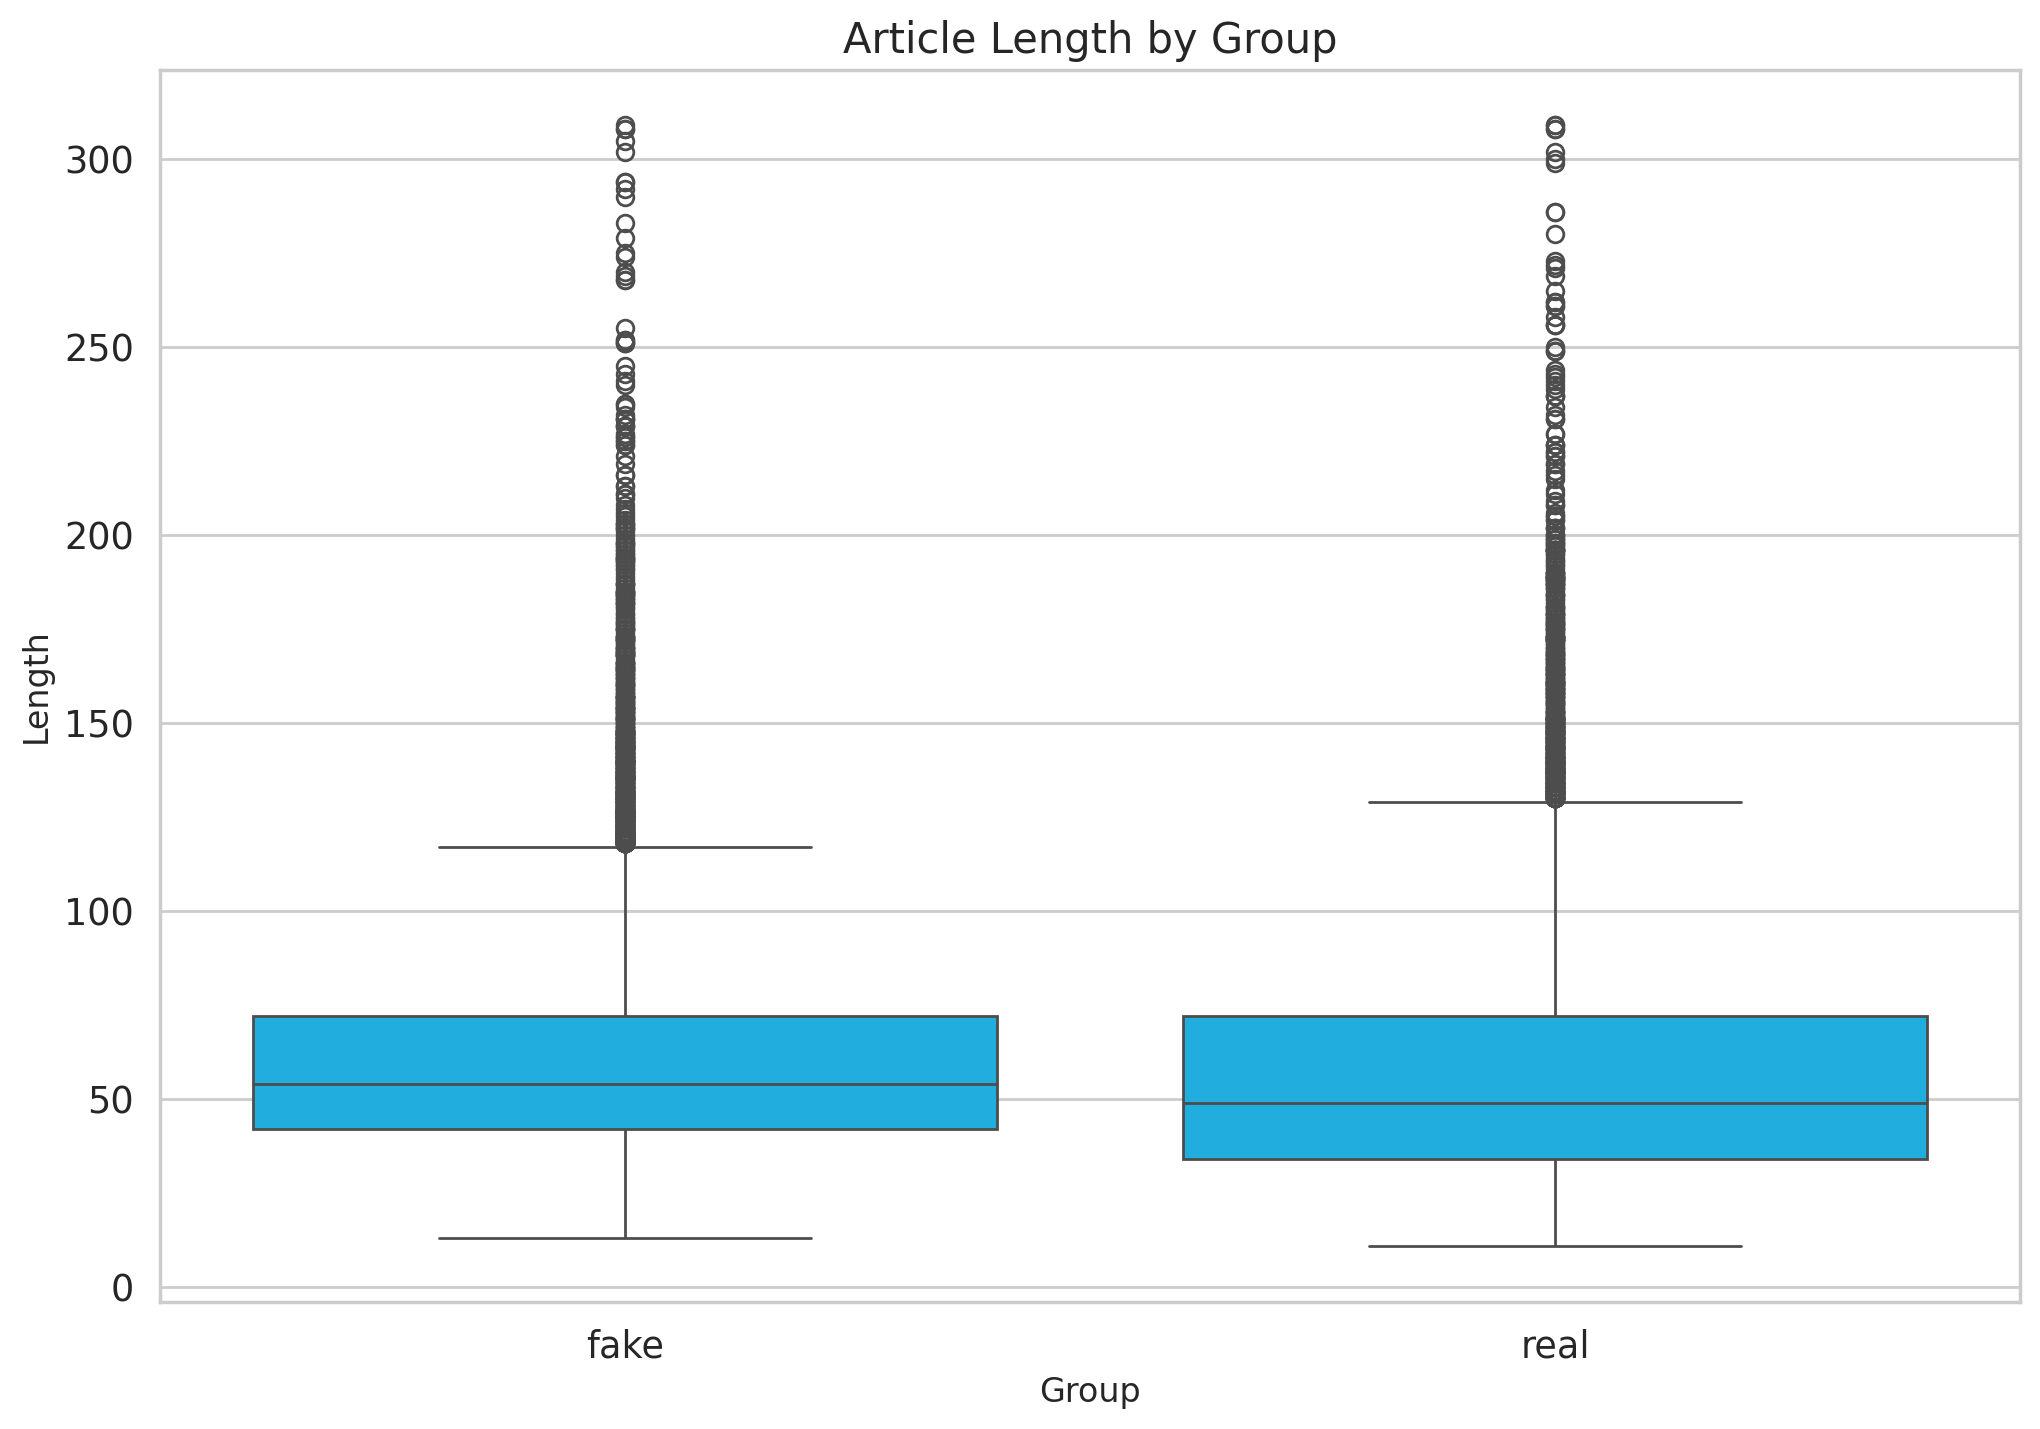

In [ ]:
sns.boxplot(x='group', y='length', data=articles_df)

plt.xlabel("Group", fontsize= 12)
plt.ylabel("Length", fontsize= 12)
plt.title("Article Length by Group", fontsize=15)

In [ ]:
# importing word_tokenize to use in function below
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Tokenize sentences
articles_df['sentences'] = articles_df['text'].apply(lambda x: nltk.sent_tokenize(x))

articles_df

,2_way_label,text,group,length,sentences
0,1,b53ndm The gopher mounds along my neighbor’s d...,fake,56,[b53ndm The gopher mounds along my neighbor’s ...
1,1,7zp9oc PsBattle: this deep sea fish 1,fake,37,[7zp9oc PsBattle: this deep sea fish 1]
2,1,axgtm4 The way the wood has aged on my deck ki...,fake,78,[axgtm4 The way the wood has aged on my deck k...
3,0,c16ygf the way this sink nozzle lines up 0,real,42,[c16ygf the way this sink nozzle lines up 0]
4,1,cjqw1c This cloud giving you the finger 1,fake,41,[cjqw1c This cloud giving you the finger 1]
...,...,...,...,...,...
35247,0,azd2u4 Bird feather on the floor looks like an...,real,58,[azd2u4 Bird feather on the floor looks like a...
35248,0,"dev99d I love you, You love me.. 0",real,34,"[dev99d I love you, You love me.. 0]"
35249,1,ca8b4p I almost stepped on this “leaf” while g...,fake,64,[ca8b4p I almost stepped on this “leaf” while ...
35250,0,bhsduw he's not a long boy 0,real,28,[bhsduw he's not a long boy 0]


#Average words per sentence
We apply the function defined below to each article to create a column of average words per sentence for each sample

In [ ]:
def avg_words_per_sent(text):
  """Feed a list of sentences (param:text) and
  returns the average number of words per sentence"""

  num_words_list = [] # List of word count per sentence

  for sent in range(len(text)):

    # Number of words in a sentence, excludes punctuation
    num_words = len([word for word in word_tokenize(text[sent]) if word.isalnum()])

    # Add number of words for sentence to the list
    num_words_list.append(num_words)


  # Compute the average
  avg_word_per_sentences = sum(num_words_list) / len(num_words_list)

  return avg_word_per_sentences

In [ ]:
# Compute avg words per sentence for each column
articles_df['words_per_sent'] = articles_df['sentences'].apply(lambda x: avg_words_per_sent(x))

In [ ]:
articles_df.head(5)

,2_way_label,text,group,length,sentences,words_per_sent
0,1,b53ndm The gopher mounds along my neighbor’s d...,fake,56,[b53ndm The gopher mounds along my neighbor’s ...,5.0
1,1,7zp9oc PsBattle: this deep sea fish 1,fake,37,[7zp9oc PsBattle: this deep sea fish 1],7.0
2,1,axgtm4 The way the wood has aged on my deck ki...,fake,78,[axgtm4 The way the wood has aged on my deck k...,17.0
3,0,c16ygf the way this sink nozzle lines up 0,real,42,[c16ygf the way this sink nozzle lines up 0],9.0
4,1,cjqw1c This cloud giving you the finger 1,fake,41,[cjqw1c This cloud giving you the finger 1],8.0


#Visualizing avg words per sentence

Text(0.5, 1.0, 'Avg words per sentence by group')

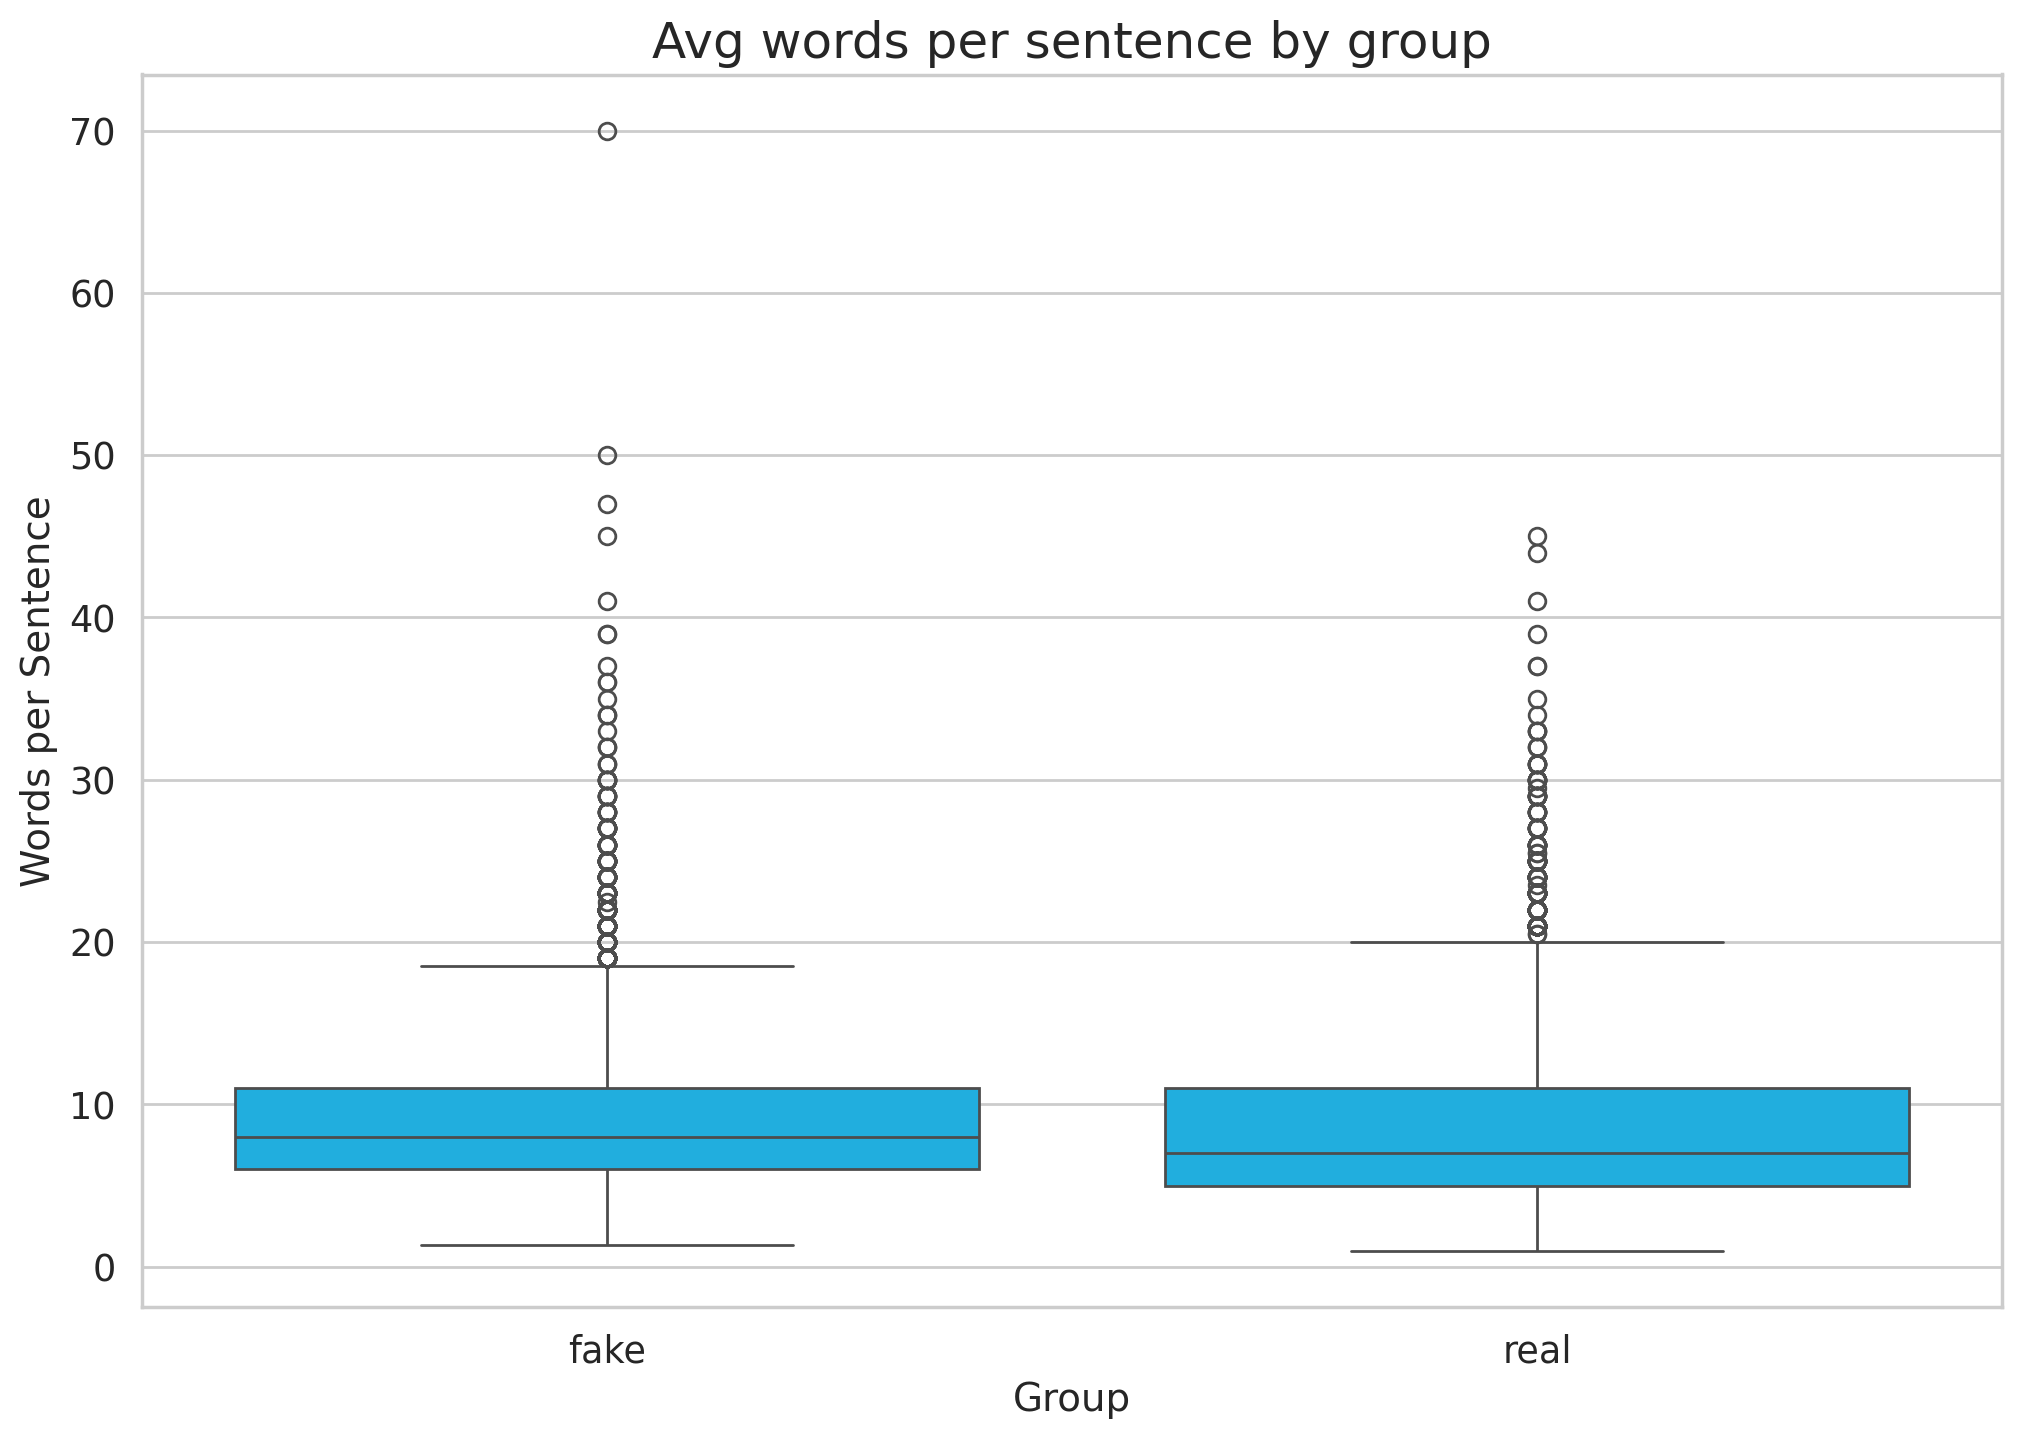

In [ ]:
sns.boxplot(x='group', y='words_per_sent', data=articles_df)

plt.xlabel("Group", fontsize= 14)
plt.ylabel("Words per Sentence", fontsize= 14)
plt.title("Avg words per sentence by group", fontsize=18)

In [ ]:
# AI text higher than 40 words per sentence
articles_df[(articles_df['words_per_sent'] > 40) & (articles_df['group'] == "real")]

,2_way_label,text,group,length,sentences,words_per_sent
3909,0,d742ss An already redacted photo that the U.S....,real,256,[d742ss An already redacted photo that the U.S...,44.0
12820,0,c0uyss MRW the mouse controlling me inside my ...,real,249,[c0uyss MRW the mouse controlling me inside my...,45.0
21752,0,bf48mf African painted wolves aka wild dogs ar...,real,231,[bf48mf African painted wolves aka wild dogs a...,41.0


In [ ]:
# Dropping articles with 100+ average words per sentence
articles_df.drop(articles_df[articles_df['words_per_sent'] > 50].index, inplace=True)

# Reset index
articles_df.reset_index(drop=True, inplace=True)

print("New count of articles")
print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake: " + str(len(articles_df[articles_df['group'] == 'fake'])))

New count of articles
# of articles for real: 16795
# of articles for fake: 18456


We can see in the two plots below that the disparity between groups has been significantly reduced.

Text(0.5, 1.0, 'Avg words per sentence by group')

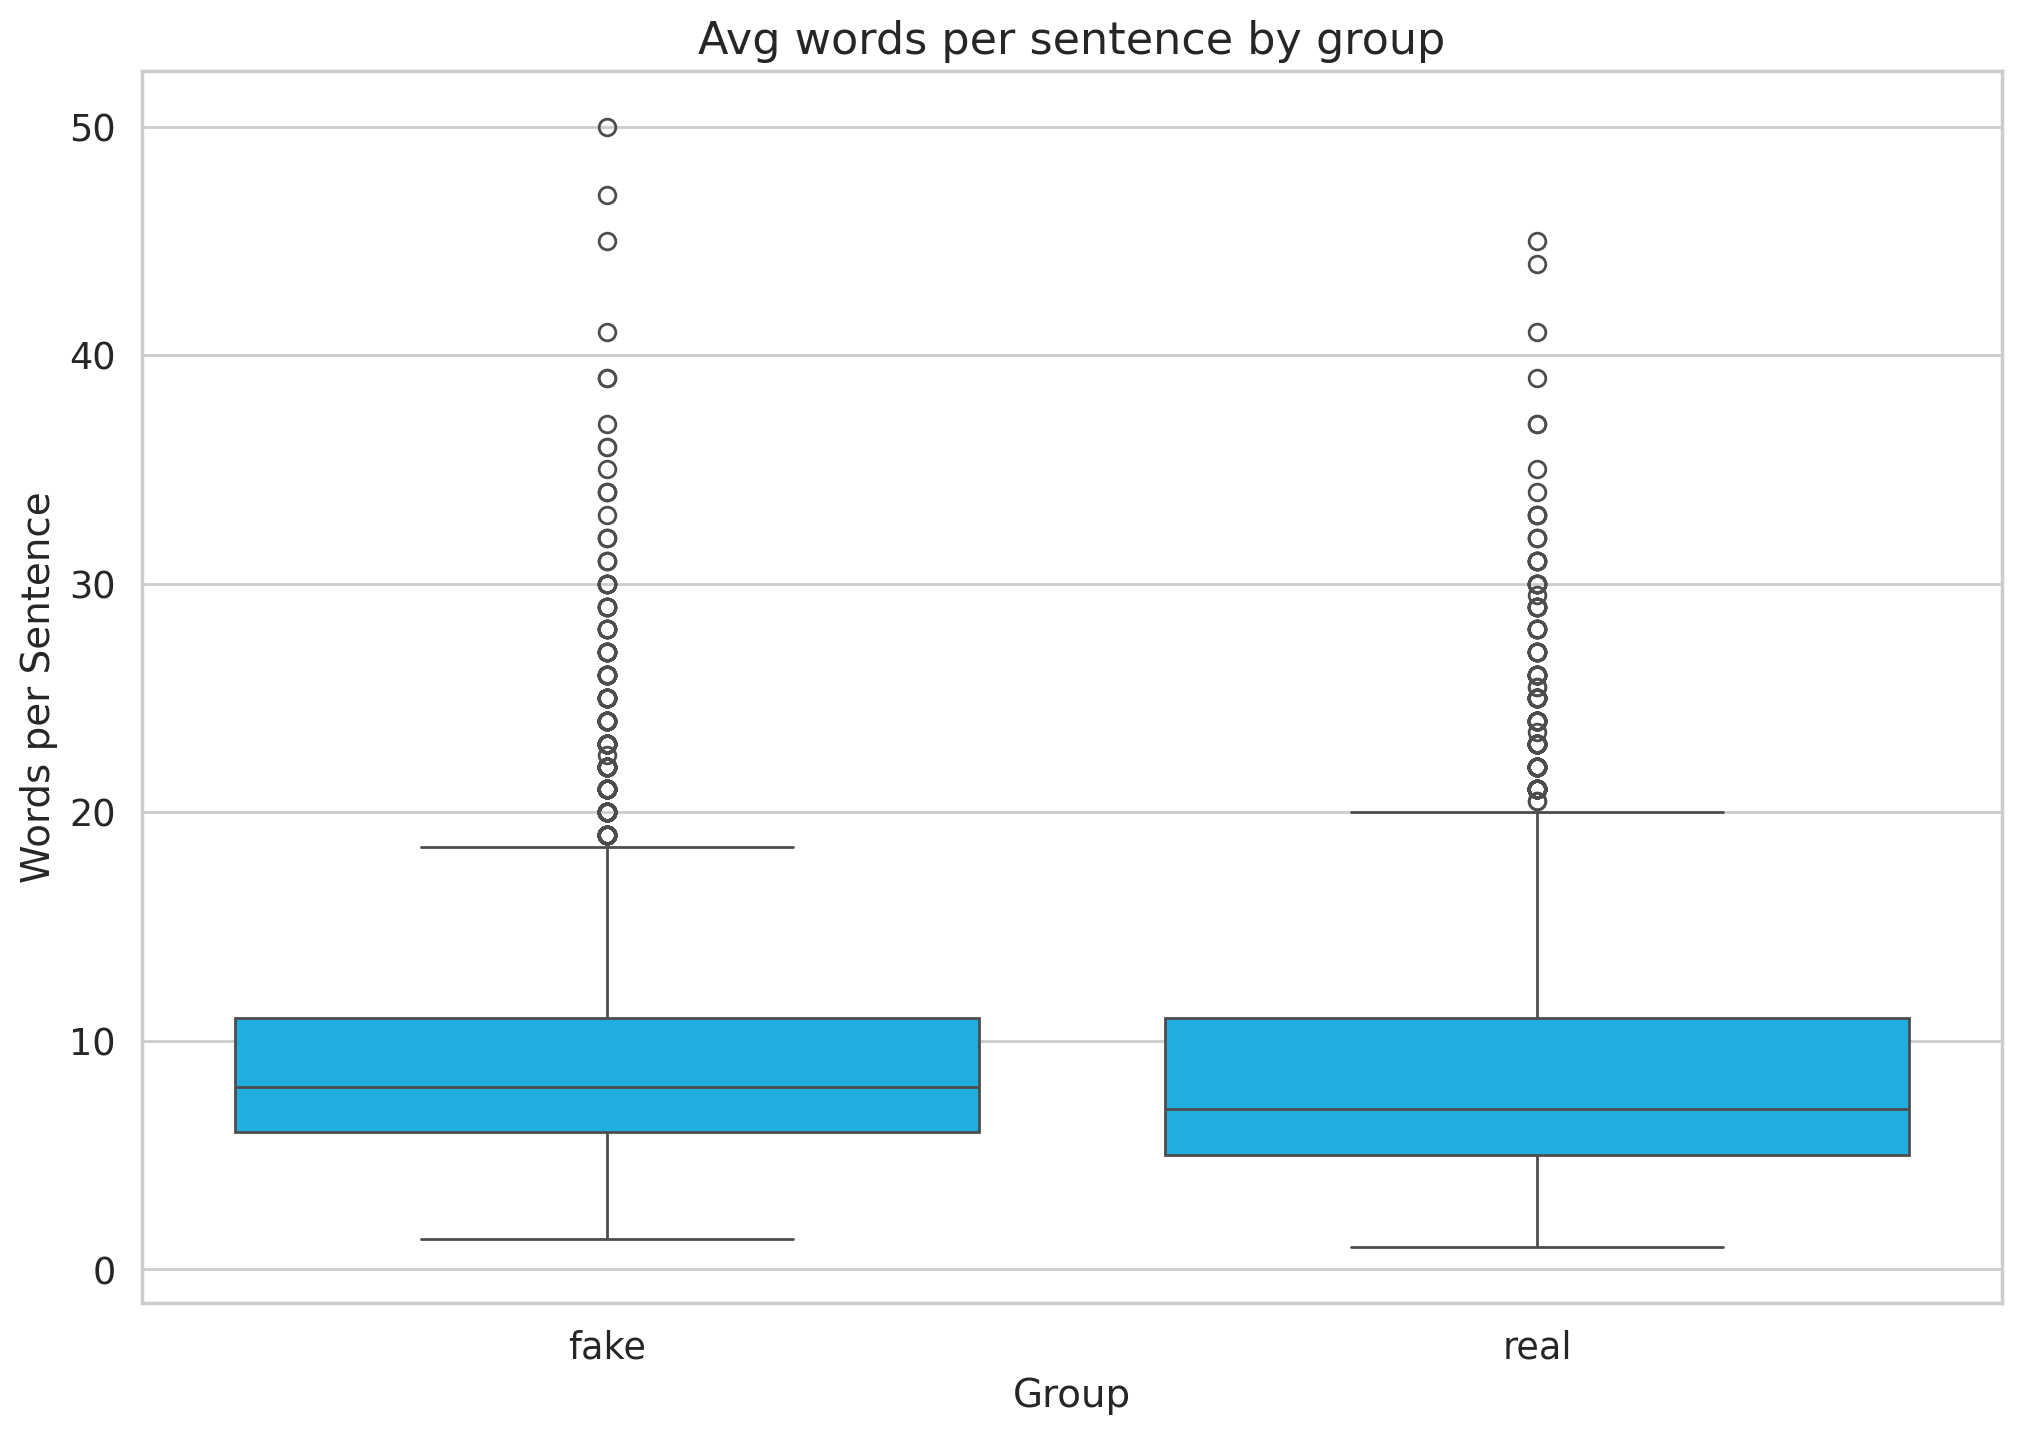

In [ ]:
# Replotting avg words per sentence
sns.boxplot(x='group', y='words_per_sent', data=articles_df)

plt.xlabel("Group", fontsize= 14)
plt.ylabel("Words per Sentence", fontsize= 14)
plt.title("Avg words per sentence by group", fontsize=16)

Text(0.5, 1.0, 'Distribution of avg. words/sentence by group')

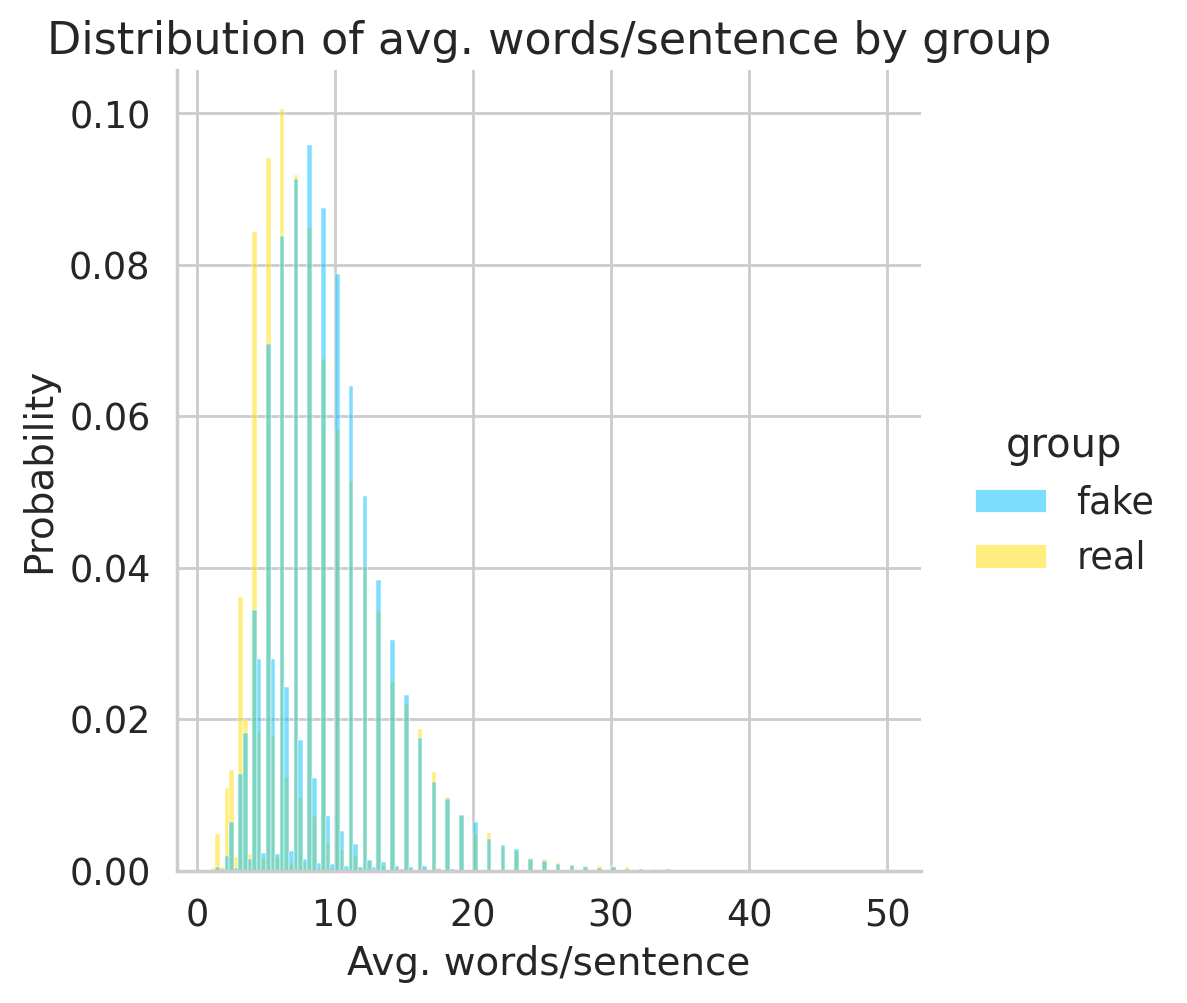

In [ ]:
# Plotting probability distribution due to uneven # of samples between groups
sns.displot(articles_df, x='words_per_sent', hue='group', stat='probability', common_norm=False)

plt.ylabel("Probability", fontsize= 14)
plt.xlabel("Avg. words/sentence", fontsize= 14)
plt.title("Distribution of avg. words/sentence by group", fontsize=16)

In [ ]:
# Create column of lowercase text
articles_df['text_lower'] = articles_df['text'].apply(lambda x: x.lower())

articles_df.head(5)

,2_way_label,text,group,length,sentences,words_per_sent,text_lower
0,1,b53ndm The gopher mounds along my neighbor’s d...,fake,56,[b53ndm The gopher mounds along my neighbor’s ...,5.0,b53ndm the gopher mounds along my neighbor’s d...
1,1,7zp9oc PsBattle: this deep sea fish 1,fake,37,[7zp9oc PsBattle: this deep sea fish 1],7.0,7zp9oc psbattle: this deep sea fish 1
2,1,axgtm4 The way the wood has aged on my deck ki...,fake,78,[axgtm4 The way the wood has aged on my deck k...,17.0,axgtm4 the way the wood has aged on my deck ki...
3,0,c16ygf the way this sink nozzle lines up 0,real,42,[c16ygf the way this sink nozzle lines up 0],9.0,c16ygf the way this sink nozzle lines up 0
4,1,cjqw1c This cloud giving you the finger 1,fake,41,[cjqw1c This cloud giving you the finger 1],8.0,cjqw1c this cloud giving you the finger 1


In [ ]:
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We create a function that tokenizes text into words and removes stop words.

In [ ]:
def tokenize_text(article):
  """ take a text string and
  - tokenizes words
  - lowers case
  - removes stopwords
  - remove non alpha tokens

  :param article_list: list of strings
  :return: list of cleaned text
  """

  tok_text = nltk.word_tokenize(article)
  tok_text = [word.lower() for word in tok_text]
  tok_text = [word for word in tok_text if word not in stopwords]
  tok_text = [word for word in tok_text if word.isalpha()]


  return tok_text

In [ ]:
# Create a list of text articles for each group
real_text_list = list(articles_df.text[articles_df.group == "real"])
fake_text_list= list(articles_df.text[articles_df.group == "fake"])


# Tokenize and clean the lists from stopwords
# each result is list of lists containing words for each article
real_word_list = [tokenize_text(article) for article in real_text_list]
fake_word_list = [tokenize_text(article) for article in fake_text_list]


#flatten the list of lists into a single list of words
flat_real_word_list = [word for article in real_word_list for word in article]
flat_fake_word_list = [word for article in fake_word_list for word in article]

#Most Common Words

In [ ]:
from collections import Counter

# 50 most common words for real
real_cnt = Counter(flat_real_word_list)
real_most_common = real_cnt.most_common(50)

# Show top 30
real_most_common[:30]

[('colorized', 1195),
 ('circa', 774),
 ('like', 540),
 ('looks', 459),
 ('happy', 438),
 ('first', 434),
 ('war', 323),
 ('new', 302),
 ('poster', 297),
 ('man', 280),
 ('little', 259),
 ('trump', 241),
 ('hitler', 228),
 ('face', 220),
 ('guy', 211),
 ('german', 205),
 ('photo', 204),
 ('one', 202),
 ('us', 193),
 ('american', 192),
 ('world', 185),
 ('soldier', 183),
 ('found', 171),
 ('president', 167),
 ('dog', 161),
 ('see', 155),
 ('look', 153),
 ('colourised', 148),
 ('soviet', 148),
 ('donald', 142)]

In [ ]:
# 50 most common words for fake_hum
fakehum_cnt = Counter(flat_fake_word_list)
fakehum_most_common = fakehum_cnt.most_common(50)

# Show top 30
fakehum_most_common[:30]

[('psbattle', 3229),
 ('like', 1370),
 ('found', 1140),
 ('looks', 969),
 ('way', 605),
 ('one', 530),
 ('cat', 466),
 ('dog', 466),
 ('tree', 457),
 ('made', 453),
 ('old', 452),
 ('got', 358),
 ('two', 351),
 ('today', 351),
 ('car', 338),
 ('water', 331),
 ('look', 295),
 ('inside', 288),
 ('sign', 287),
 ('little', 274),
 ('local', 262),
 ('house', 260),
 ('work', 258),
 ('back', 234),
 ('new', 233),
 ('guy', 223),
 ('years', 213),
 ('left', 211),
 ('came', 209),
 ('ice', 208)]

#Word Clouds

In [ ]:
from wordcloud import WordCloud

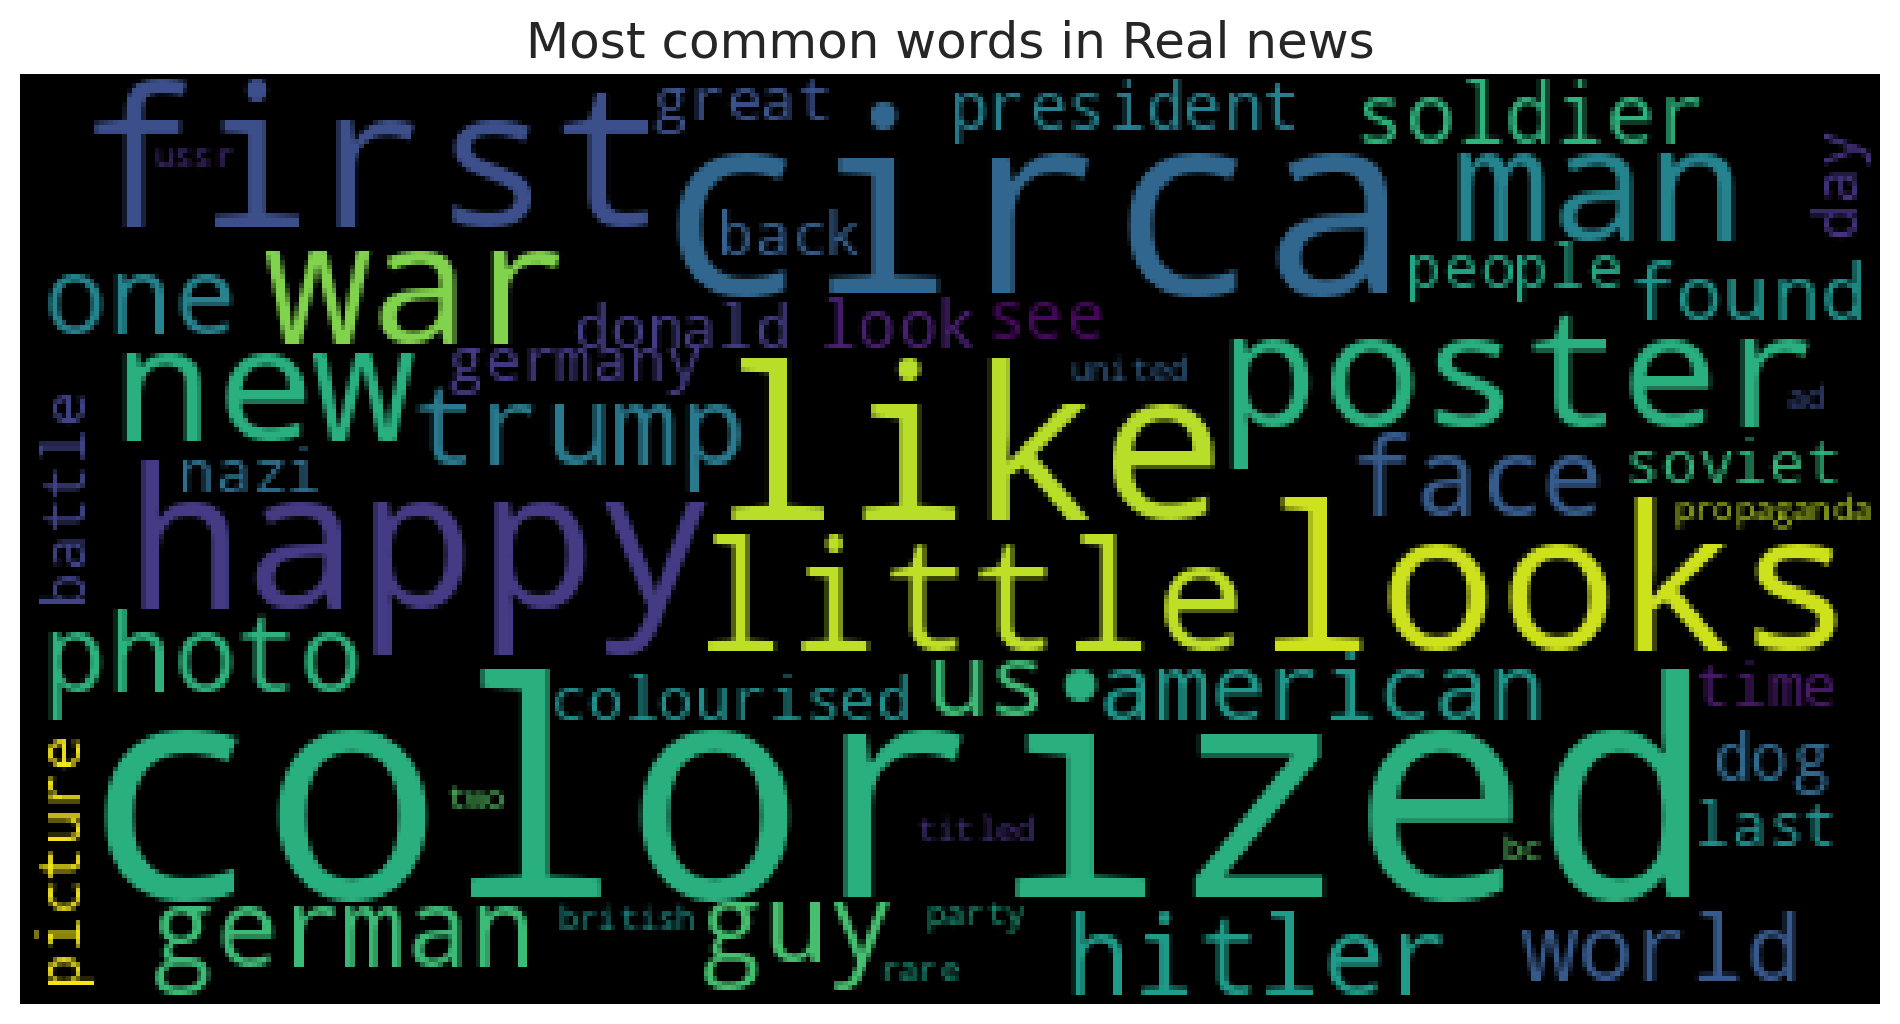

In [ ]:
real_wordcloud = WordCloud(background_color="black", max_words=50).generate_from_frequencies(real_cnt)
plt.imshow(real_wordcloud)
plt.axis("off")
plt.title("Most common words in Real news", fontsize=18)
plt.show()

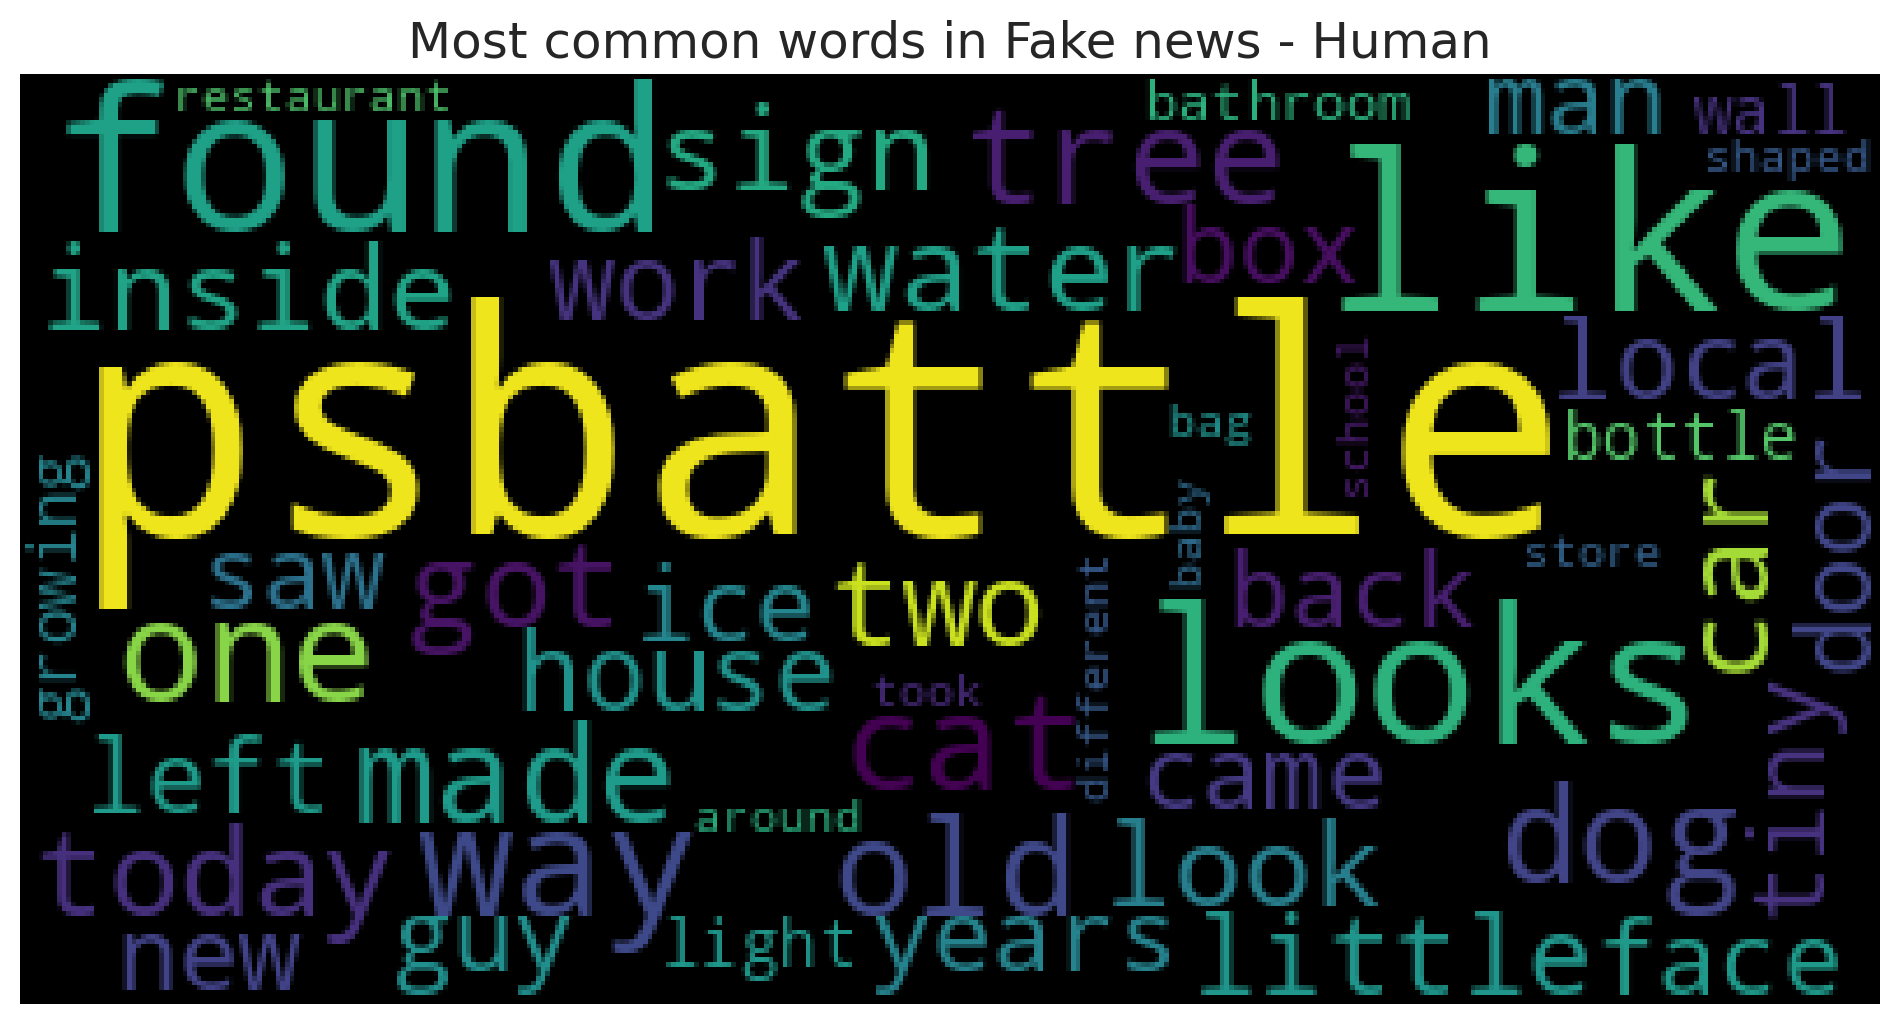

In [ ]:
fakehum_wordcloud = WordCloud(background_color="black", max_words=50).generate_from_frequencies(fakehum_cnt)
plt.imshow(fakehum_wordcloud)
plt.axis("off")
plt.title("Most common words in Fake news", fontsize=18)
plt.show()

#Sentiment Score

In [ ]:
!pip install afinn
from afinn import Afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53430 sha256=8415b2c2d255e7061a4dc71f2e0d66cce307a54e147dd1076d001b75183e3d7b
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [ ]:
afinn = Afinn(language='en')

# Example of sentiment scores
print('Score for "I hate this and it sucks": ', afinn.score("I hate this and it sucks"))
print('Score for "I love it and it\'s great!": ', afinn.score("I love it and it's great!"))

Score for "I hate this and it sucks":  -6.0
Score for "I love it and it's great!":  6.0


In [ ]:
# Create sentiment column
articles_df['sentiment'] = articles_df.text.apply(lambda x: afinn.score(x))

In [ ]:
articles_df.head(5)

,2_way_label,text,group,length,sentences,words_per_sent,text_lower,sentiment
0,1,b53ndm The gopher mounds along my neighbor’s d...,fake,56,[b53ndm The gopher mounds along my neighbor’s ...,5.0,b53ndm the gopher mounds along my neighbor’s d...,0.0
1,1,7zp9oc PsBattle: this deep sea fish 1,fake,37,[7zp9oc PsBattle: this deep sea fish 1],7.0,7zp9oc psbattle: this deep sea fish 1,0.0
2,1,axgtm4 The way the wood has aged on my deck ki...,fake,78,[axgtm4 The way the wood has aged on my deck k...,17.0,axgtm4 the way the wood has aged on my deck ki...,2.0
3,0,c16ygf the way this sink nozzle lines up 0,real,42,[c16ygf the way this sink nozzle lines up 0],9.0,c16ygf the way this sink nozzle lines up 0,0.0
4,1,cjqw1c This cloud giving you the finger 1,fake,41,[cjqw1c This cloud giving you the finger 1],8.0,cjqw1c this cloud giving you the finger 1,0.0


#Visualizing sentiment

Text(0.5, 1.0, 'Sentiment by group')

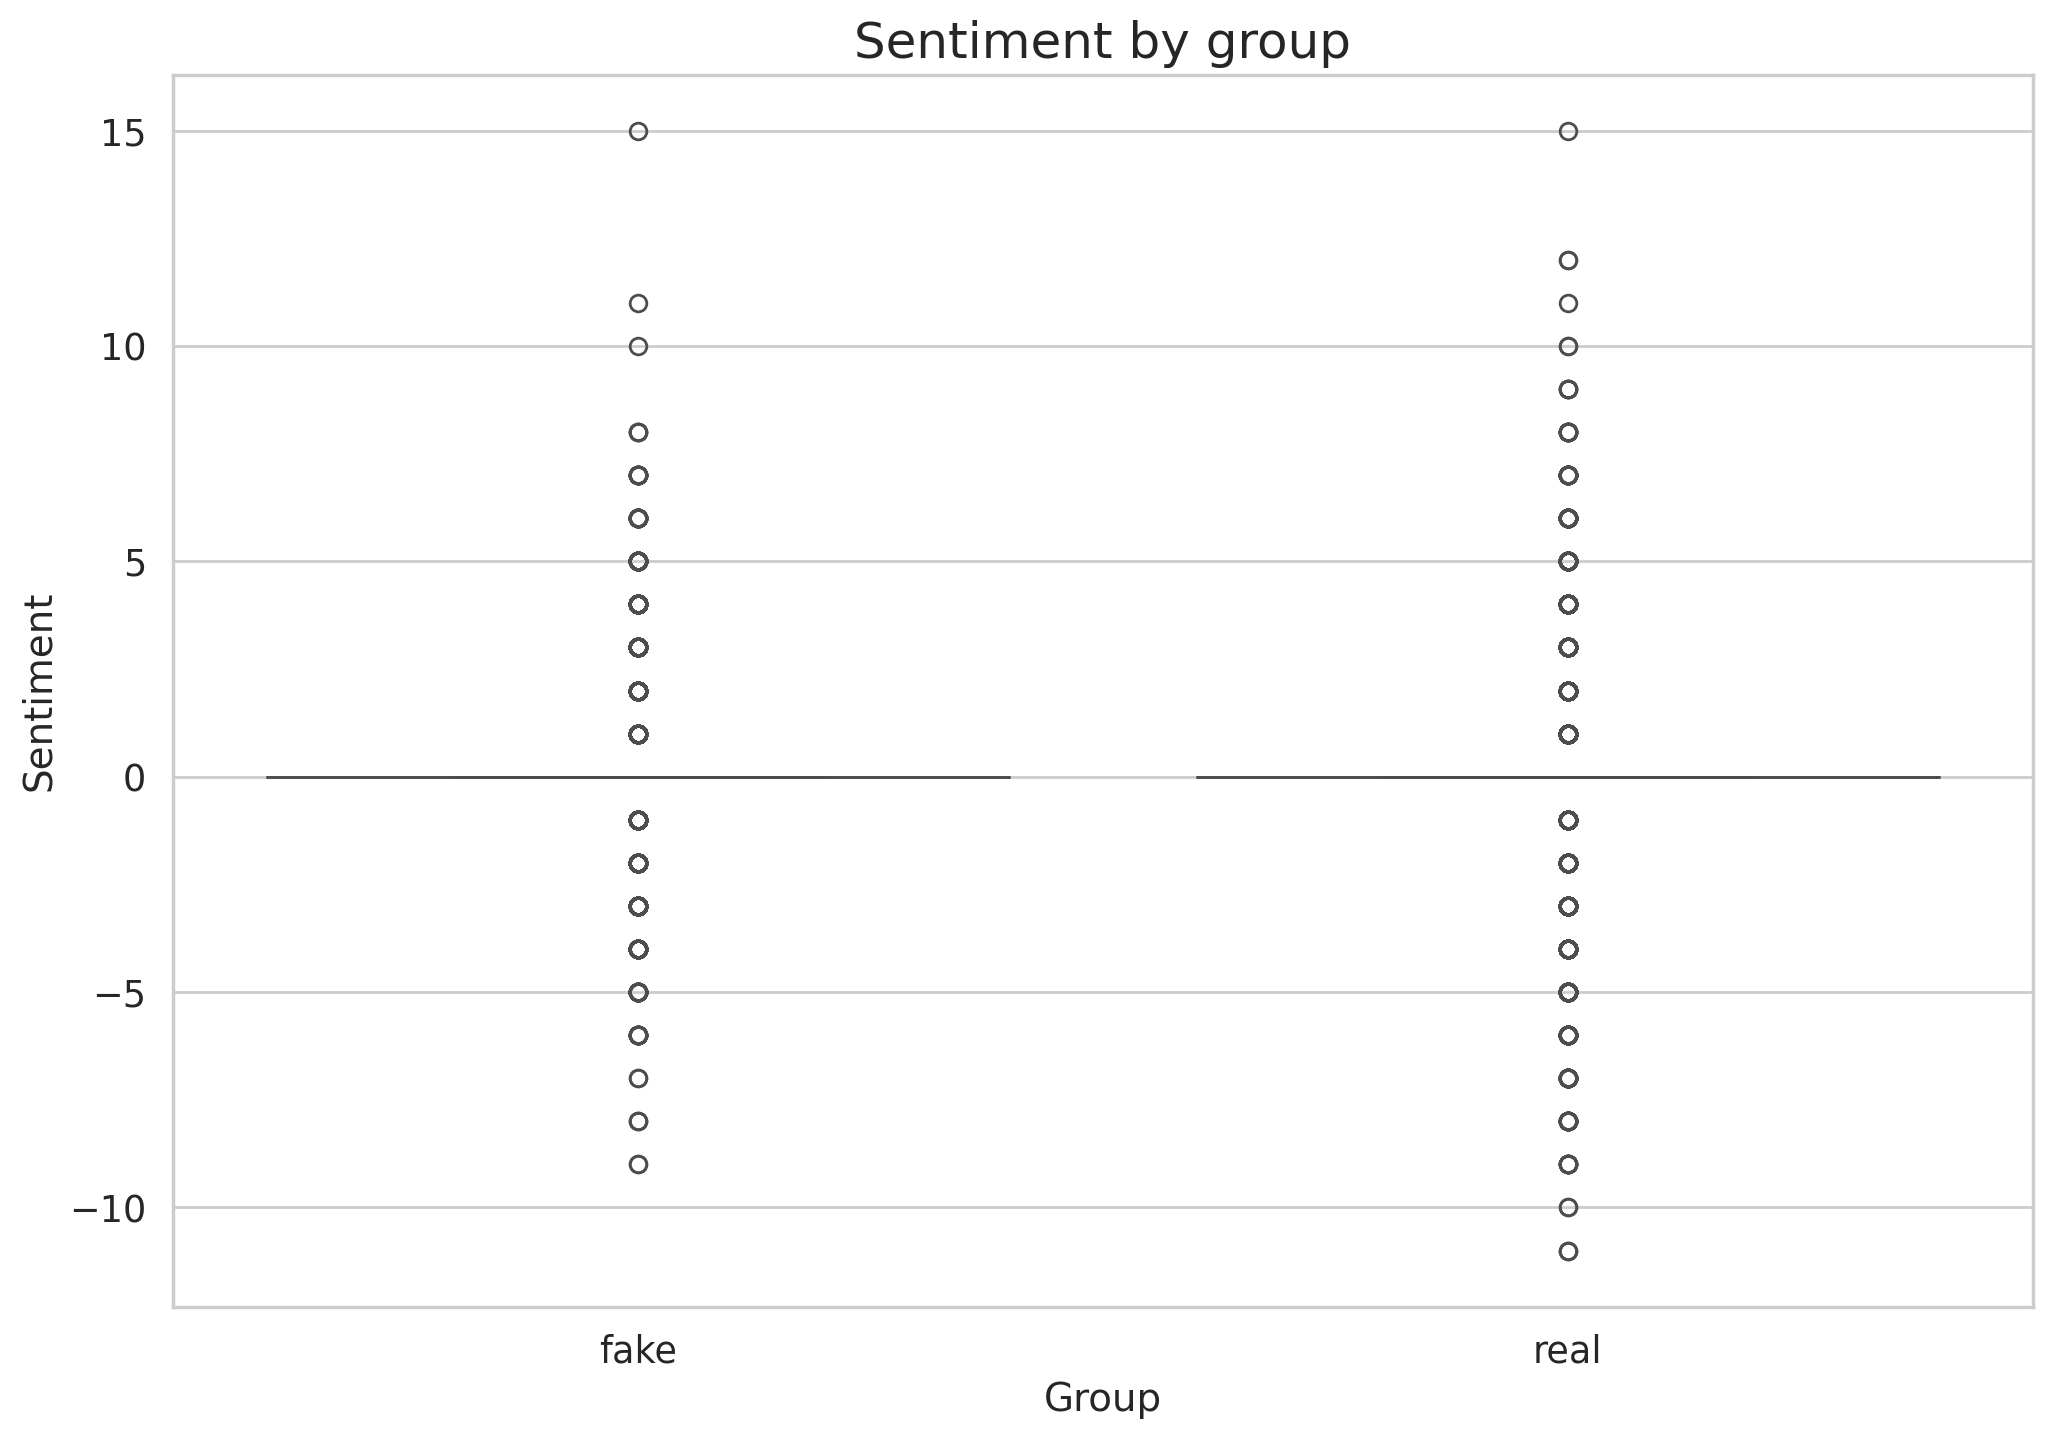

In [ ]:
sns.boxplot(x='group', y='sentiment', data=articles_df)

plt.xlabel("Group", fontsize= 14)
plt.ylabel("Sentiment", fontsize= 14)
plt.title("Sentiment by group", fontsize=18)

In [ ]:
# Final df
articles_df.head()

,2_way_label,text,group,length,sentences,words_per_sent,text_lower,sentiment
0,1,b53ndm The gopher mounds along my neighbor’s d...,fake,56,[b53ndm The gopher mounds along my neighbor’s ...,5.0,b53ndm the gopher mounds along my neighbor’s d...,0.0
1,1,7zp9oc PsBattle: this deep sea fish 1,fake,37,[7zp9oc PsBattle: this deep sea fish 1],7.0,7zp9oc psbattle: this deep sea fish 1,0.0
2,1,axgtm4 The way the wood has aged on my deck ki...,fake,78,[axgtm4 The way the wood has aged on my deck k...,17.0,axgtm4 the way the wood has aged on my deck ki...,2.0
3,0,c16ygf the way this sink nozzle lines up 0,real,42,[c16ygf the way this sink nozzle lines up 0],9.0,c16ygf the way this sink nozzle lines up 0,0.0
4,1,cjqw1c This cloud giving you the finger 1,fake,41,[cjqw1c This cloud giving you the finger 1],8.0,cjqw1c this cloud giving you the finger 1,0.0


In [ ]:
# articles_df.describe()
print("Avg length - real: " + str(articles_df[articles_df['group']== 'real'].length.mean()))
print("Avg length - fake: " + str(articles_df[articles_df['group']== 'fake'].length.mean()))

Avg length - real: 57.156475141411136
Avg length - fake: 60.558138274815775


Text(0.5, 1.0, 'Avg words per sentence by group')

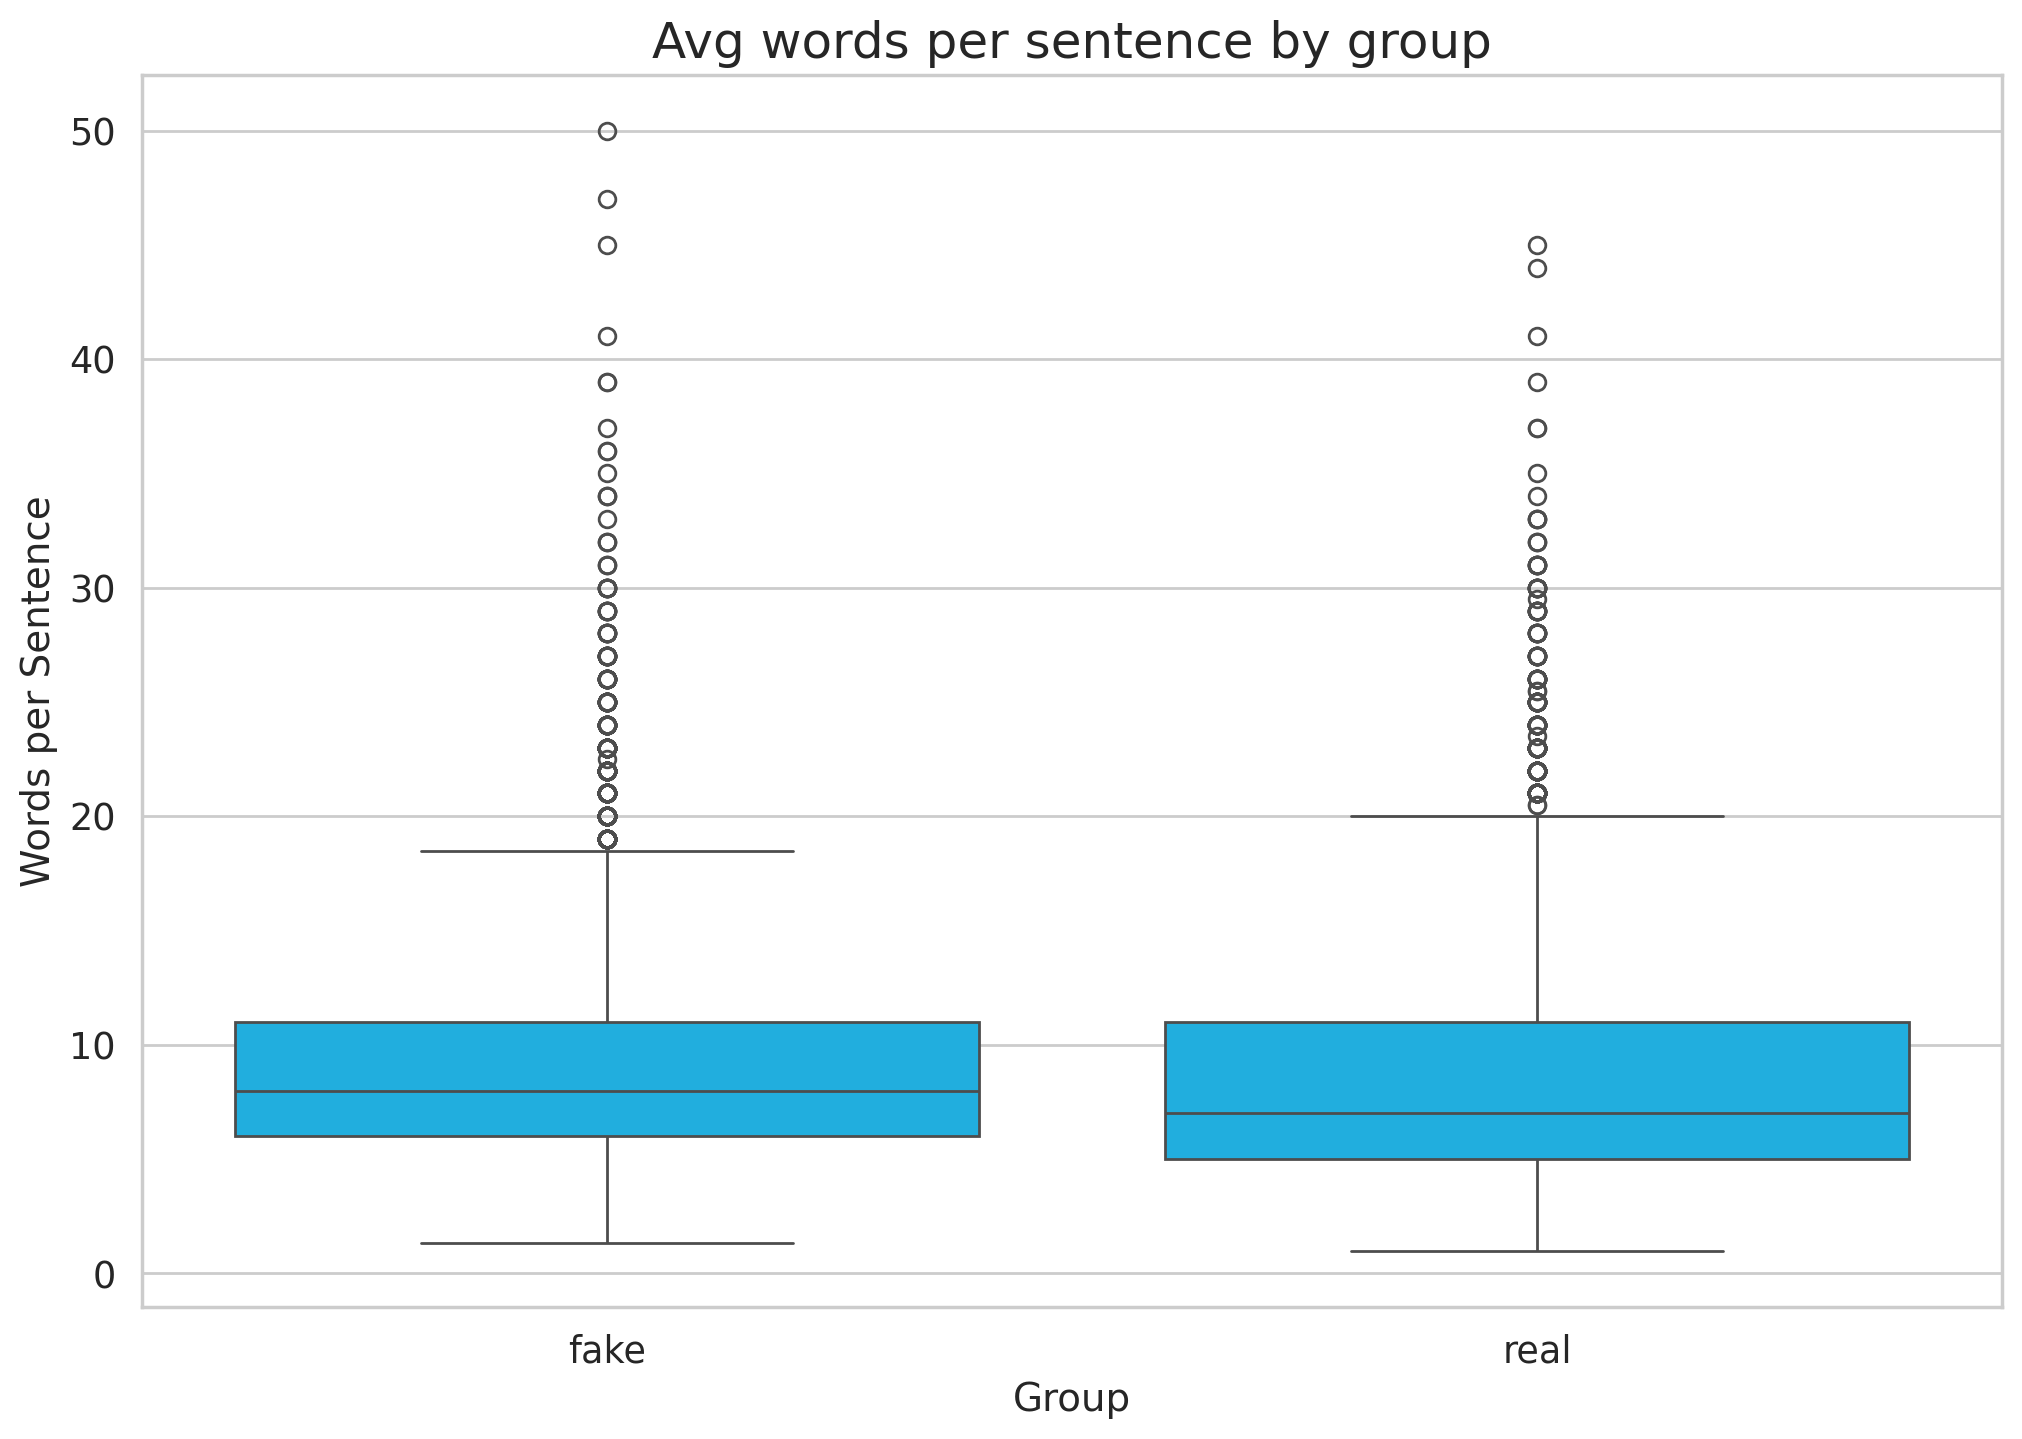

In [ ]:
sns.boxplot(x='group', y='words_per_sent', data=articles_df)

plt.xlabel("Group", fontsize= 14)
plt.ylabel("Words per Sentence", fontsize= 14)
plt.title("Avg words per sentence by group", fontsize=18)

#Machine Learning Models

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

real_text = articles_df[articles_df['group'] == "real"][['text','group']][:1000]
fake_text = articles_df[articles_df['group']=='fake'][['text','group']][:500]

# Clustering
clustering_text_X = real_text['text'].append(fake_text['text'])

# Classification - Real vs. Fake
# X = real__text_X | y = real__text_y
real_text_X = real_text['text'][:500].append(fake_text['text'])
real_text_y_raw = real_text['group'][:500].append(fake_text['group'])
real_text_y = []
for val in real_text_y_raw:
  if val == 'real':
    real_text_y.append(0)
  else:
    real_text_y.append(1)

<ipython-input-62-7602b5901a5c>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clustering_text_X = real_text['text'].append(fake_text['text'])
<ipython-input-62-7602b5901a5c>:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  real_text_X = real_text['text'][:500].append(fake_text['text'])
<ipython-input-62-7602b5901a5c>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  real_text_y_raw = real_text['group'][:500].append(fake_text['group'])


In [ ]:
tf_idf_vectorizor = TfidfVectorizer()
tf_idf = tf_idf_vectorizor.fit_transform(real_text_X)
tf_idf_norm = normalize(tf_idf)
X_real = tf_idf_norm.toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


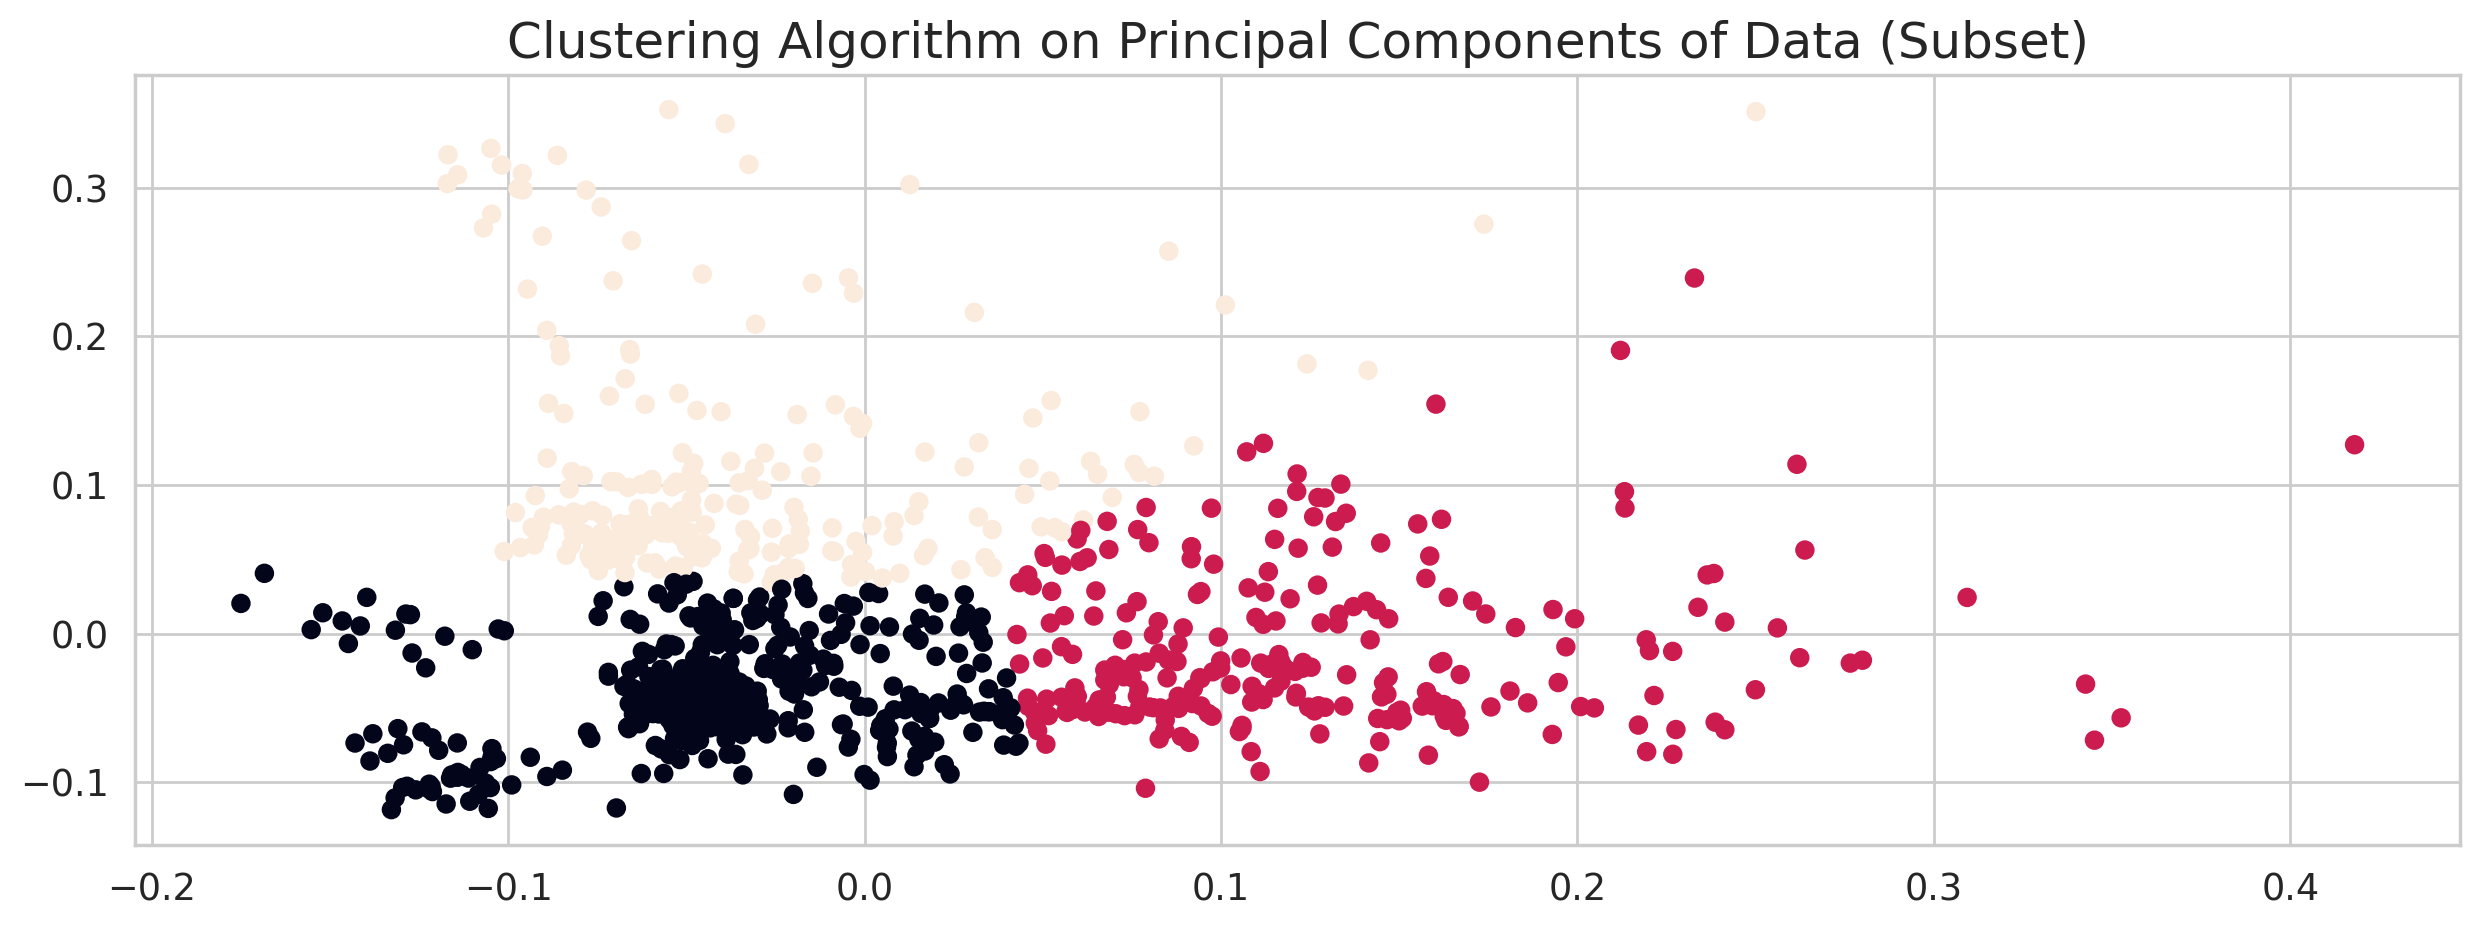

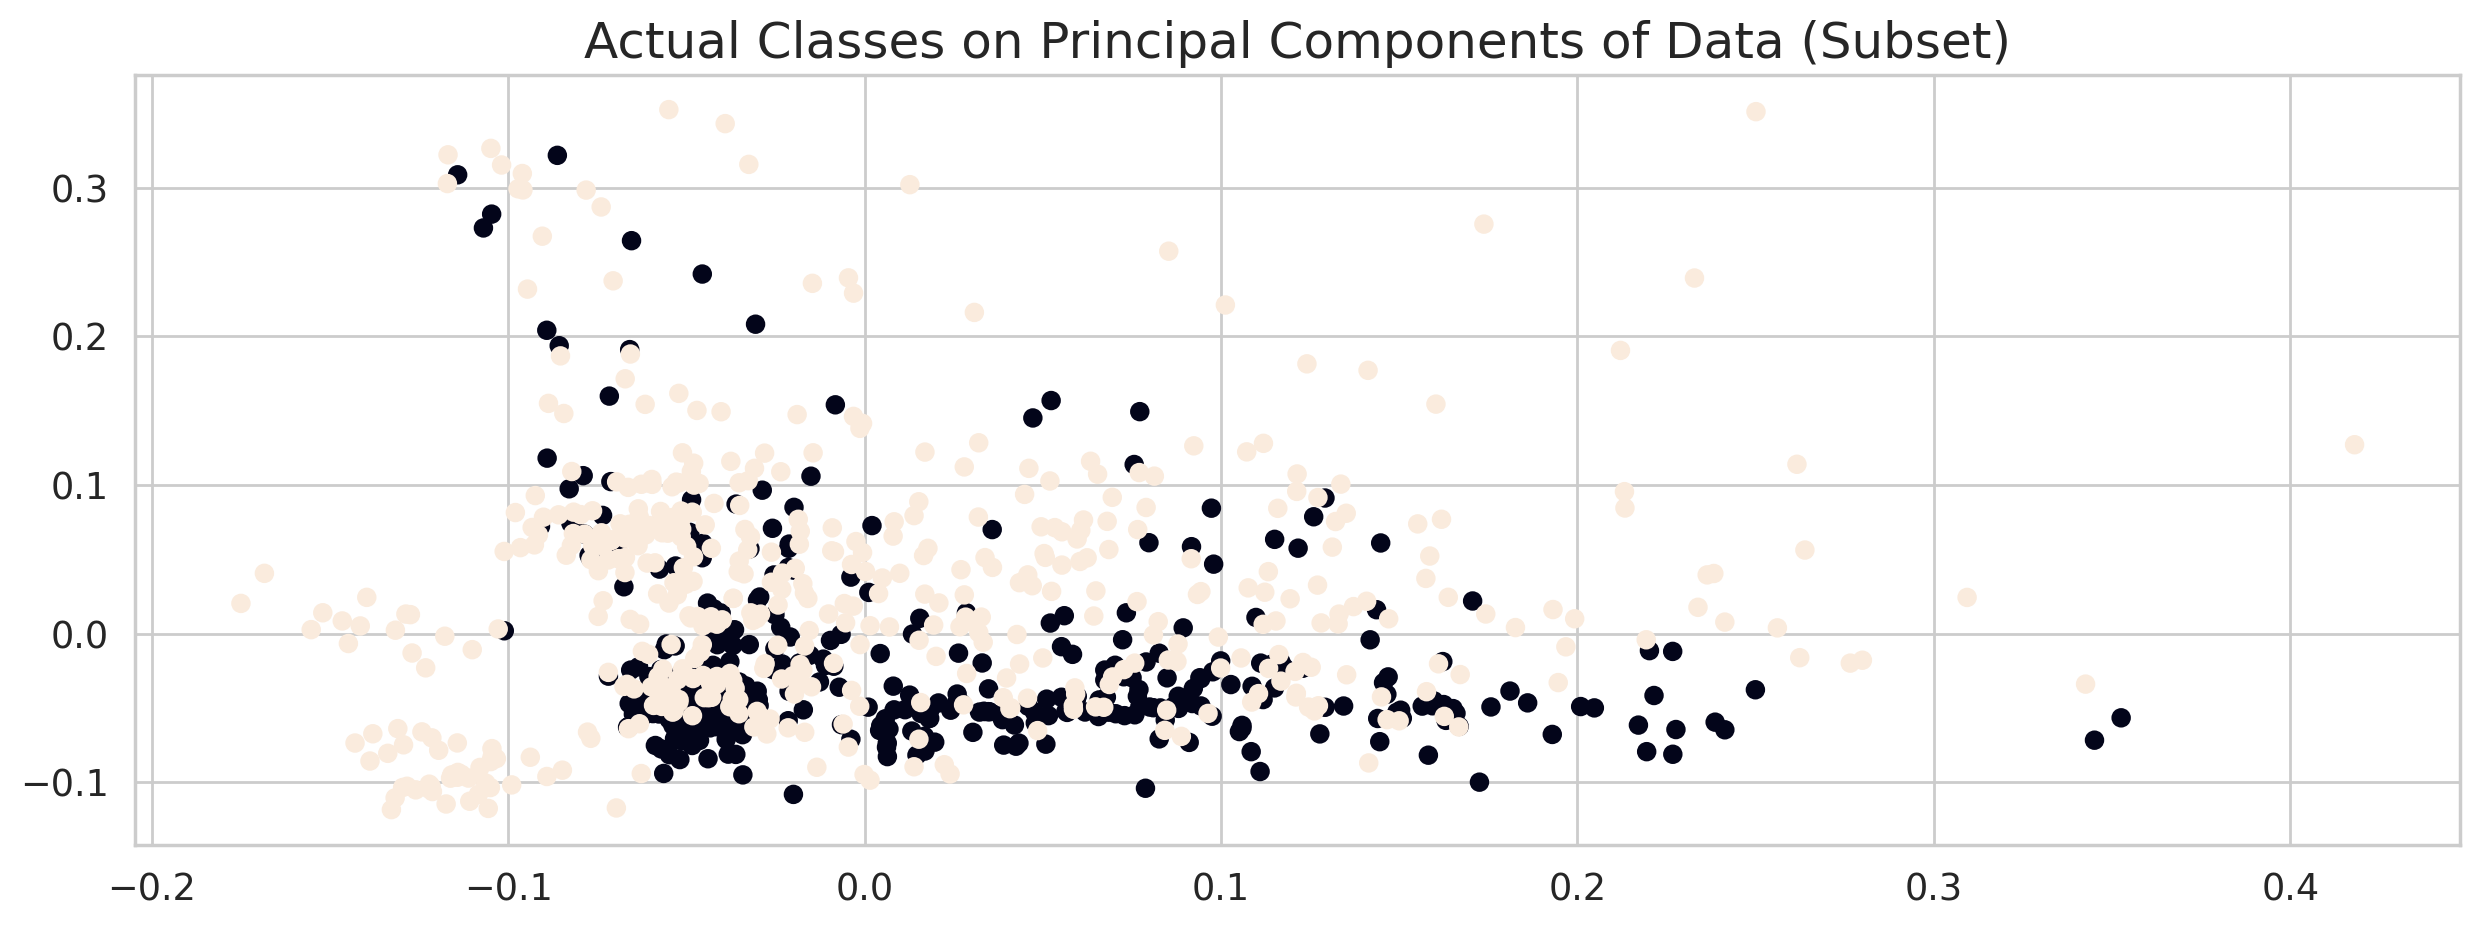

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_real)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

clustering_df = pd.DataFrame(Y_sklearn)
clustering_df.columns = ['x', 'y']
clustering_df['prediction'] = prediction

plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = prediction);
plt.title("Clustering Algorithm on Principal Components of Data (Subset)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.figure()
plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = real_text_y);
plt.title("Actual Classes on Principal Components of Data (Subset)", size = 18)
plt.gcf().set_size_inches(15,5)

#Clustering Part II - All Data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

# Limiting to 16,000 to control for different samples sizes between groups
real_text = articles_df[articles_df['group'] == "real"][['sentences','group']][:16000]
fake_text = articles_df[articles_df['group']=='fake'][['sentences','group']][:16000]

# Clustering
clustering_text_X = real_text['sentences'].append(fake_text['sentences'])

# Classification - Real vs. Fake
# X = real_text_X | y = real_text_y
real_text_X = real_text['sentences'].append(fake_text['sentences'])
real_text_y_raw = real_text['group'].append(fake_text['group'])
real_text_y = []
for val in real_text_y_raw:
  if val == 'real':
    real_text_y.append(0)
  else:
    real_text_y.append(1)

<ipython-input-66-21cdc6d2d328>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clustering_text_X = real_text['sentences'].append(fake_text['sentences'])
<ipython-input-66-21cdc6d2d328>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  real_text_X = real_text['sentences'].append(fake_text['sentences'])
<ipython-input-66-21cdc6d2d328>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  real_text_y_raw = real_text['group'].append(fake_text['group'])


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc

real_text_X_raw = Dictionary(real_text_X)

real_corpus = [real_text_X_raw.doc2bow(line) for line in real_text_X]

real_model = TfidfModel(real_corpus)

real_vector = real_model[real_corpus]

real_X = corpus2csc(real_vector).T

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


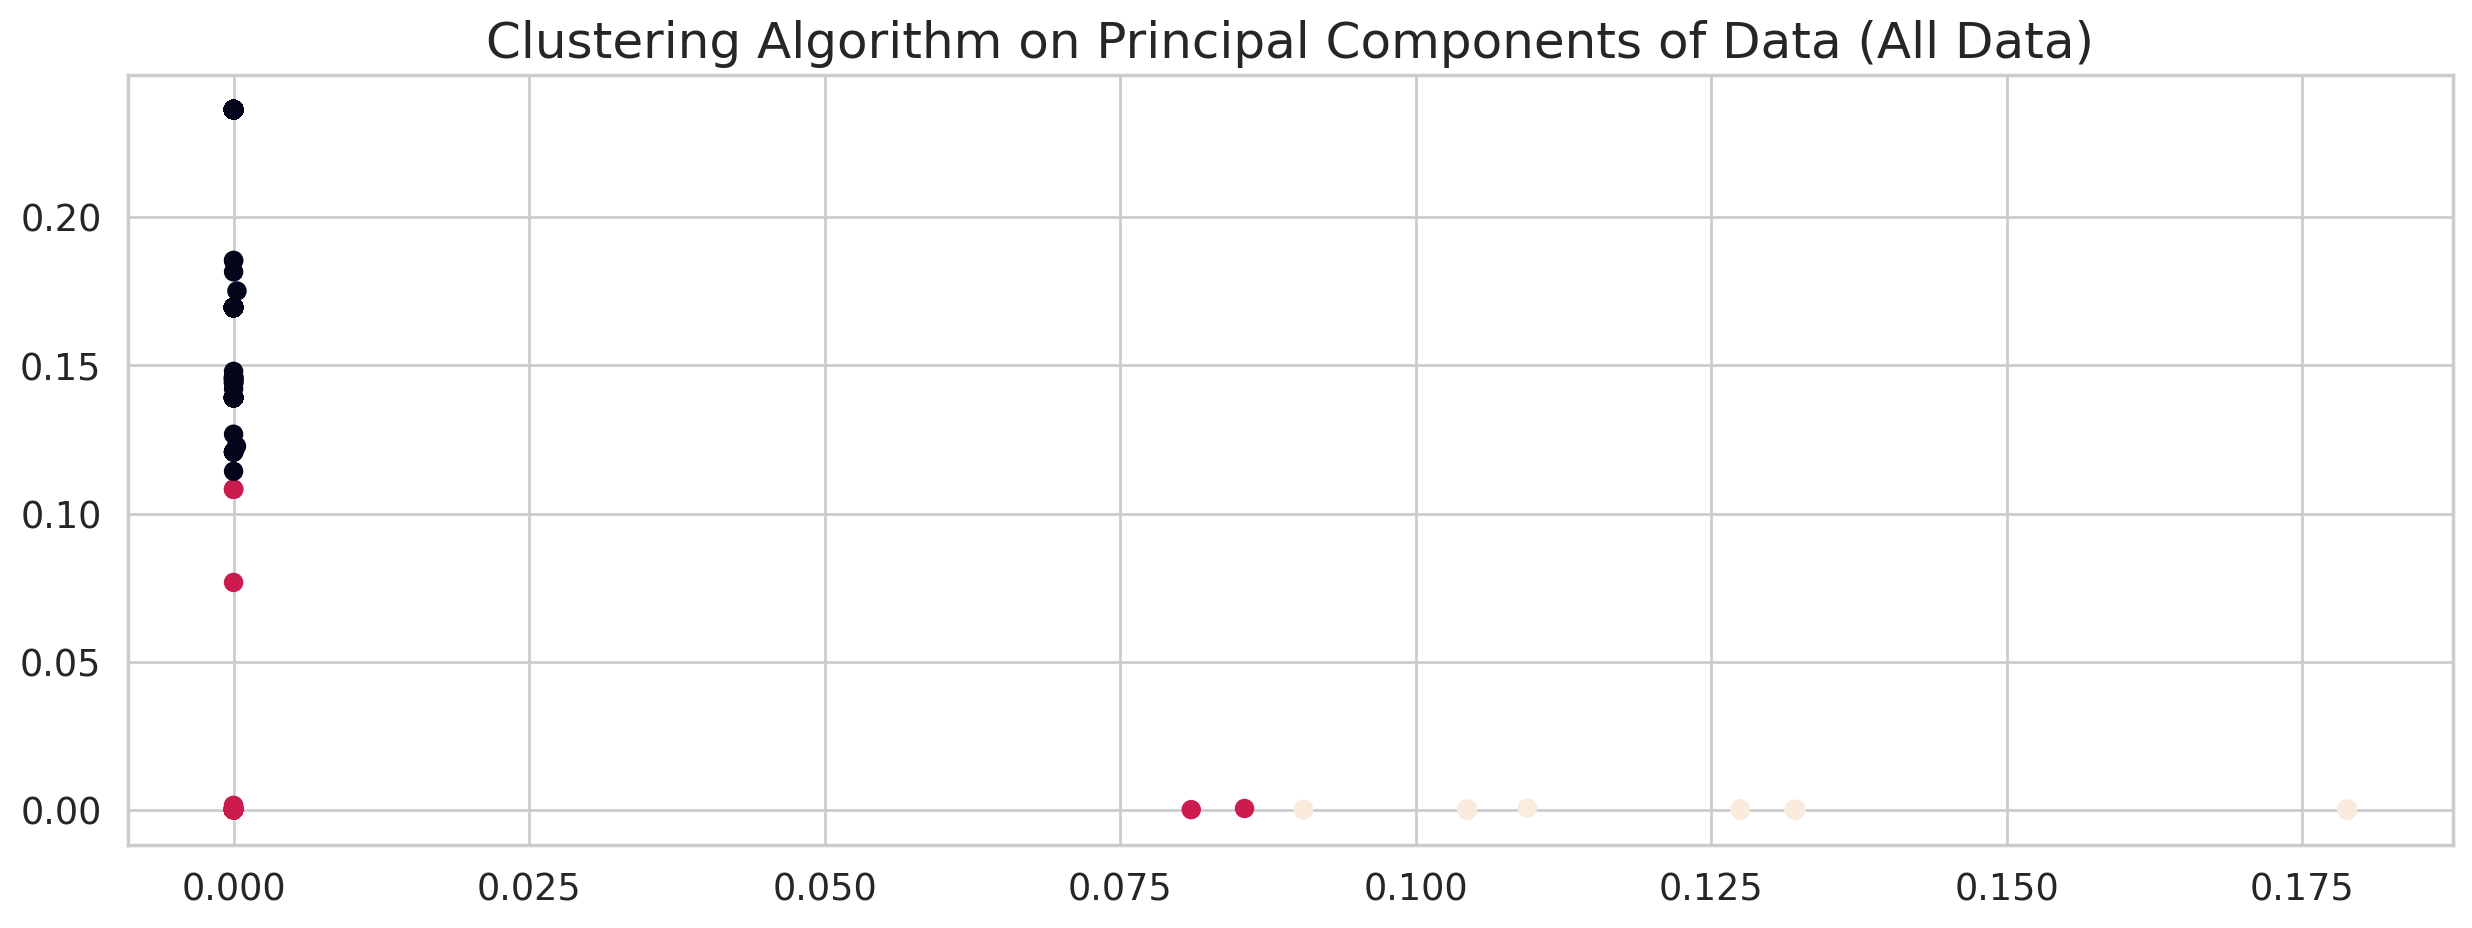

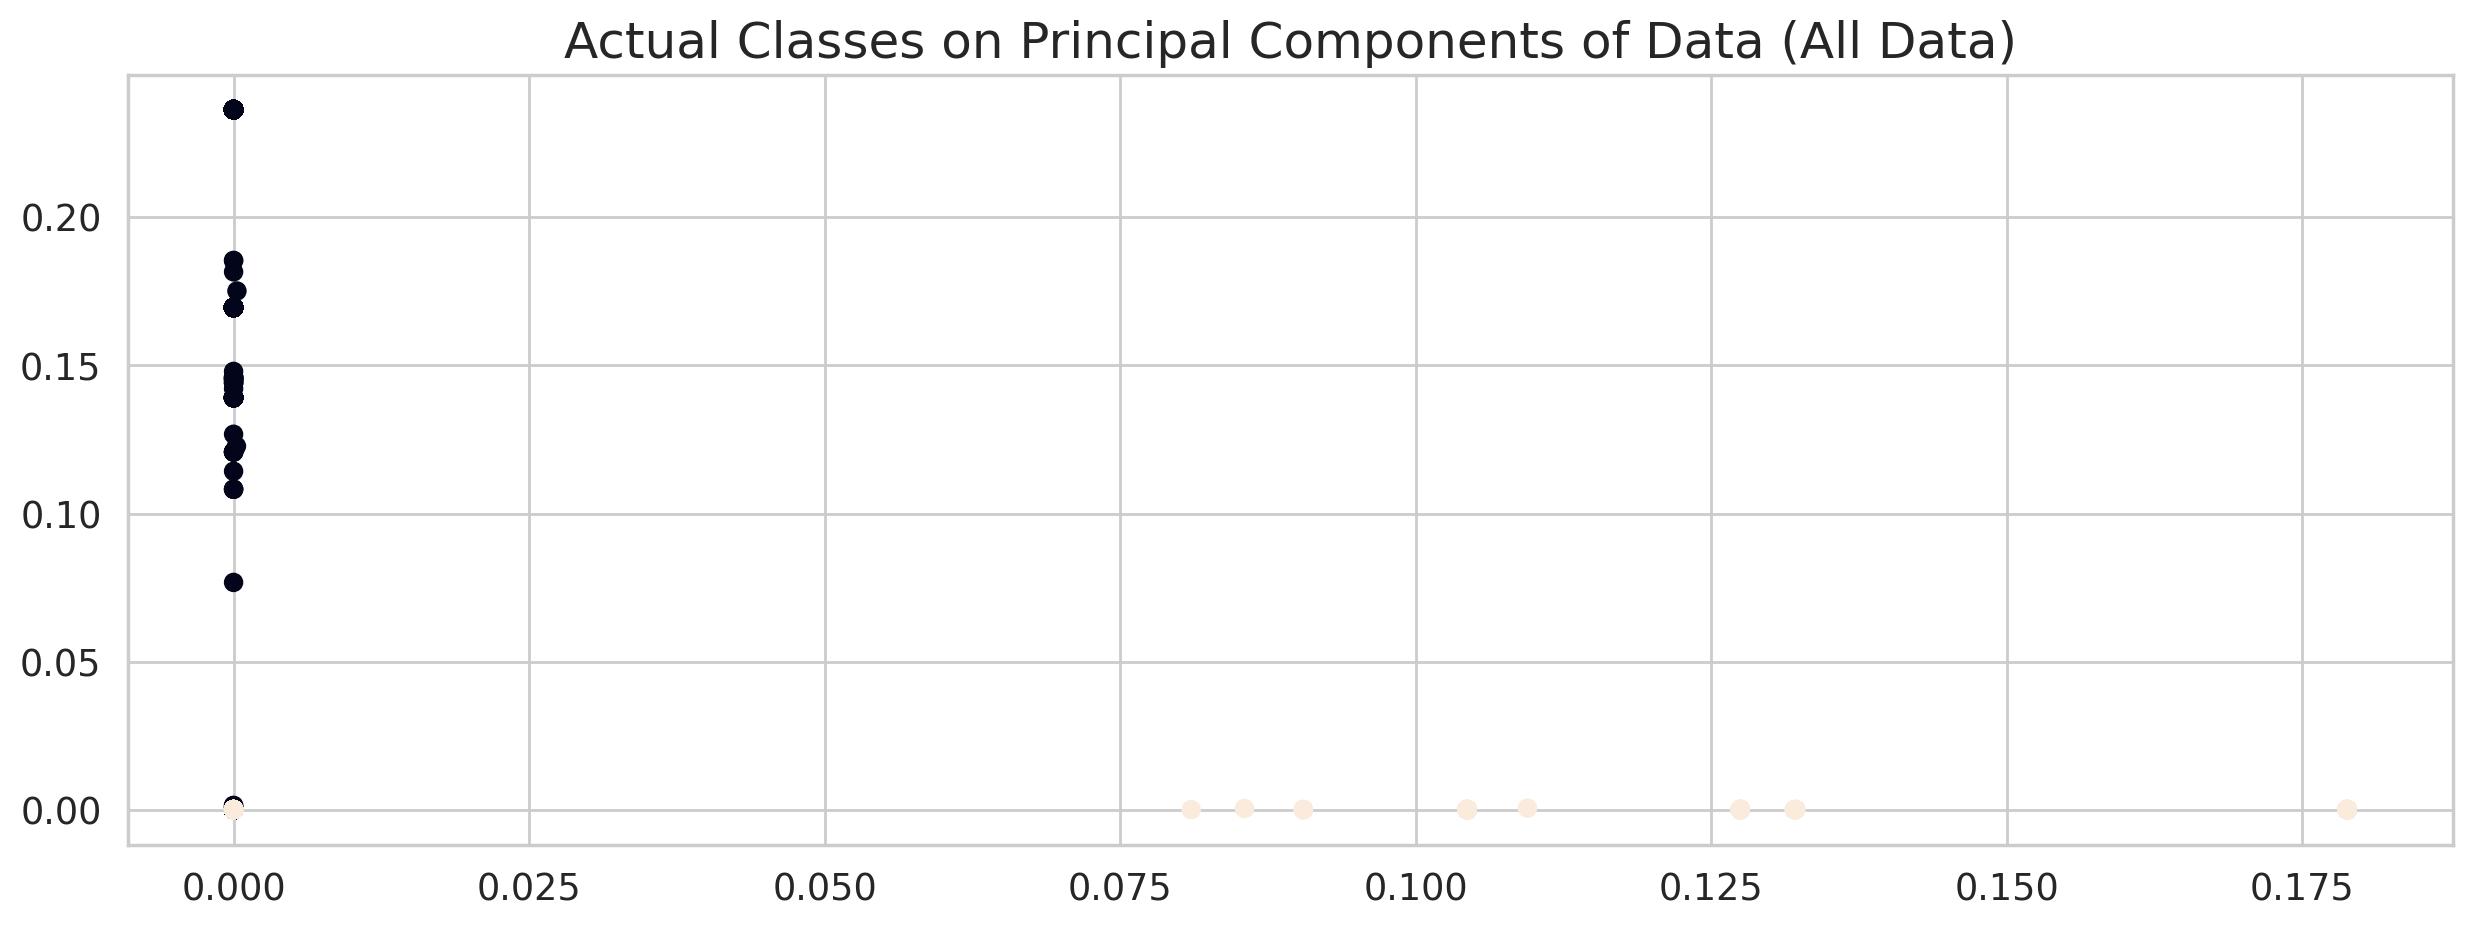

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

sklearn_pca = TruncatedSVD(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(real_X)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

clustering_df = pd.DataFrame(Y_sklearn)
clustering_df.columns = ['x', 'y']
clustering_df['prediction'] = prediction


plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = prediction);
plt.title("Clustering Algorithm on Principal Components of Data (All Data)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.figure()
plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = real_text_y);
plt.title("Actual Classes on Principal Components of Data (All Data)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = real_X
y = real_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression()
logit = lr.fit(X_train,y_train)
y_predict = logit.predict(X_test)


print("Accuracy: ", logit.score(X, y)*100,"%")

Accuracy:  93.20625 %
